In [8]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
%matplotlib inline

import itertools
from kernels import HMC_our, HMC_vanilla, Reverse_kernel_sampling
from target import GMM_target, GMM_target2, Funnel, Gaussian_target #, Banana
from args import get_args

import matplotlib
matplotlib.rcParams.update({'font.size': 20})

import pdb

In [9]:
true_theta = torch.tensor([[-0.296278  ,  2.676448  , -0.1408463 , -0.84409505,  0.29053846,
        -0.28383088, -1.4534557 ,  2.3736813 , -0.01774164, -2.7884495 ],
       [-0.37882465,  0.7045725 , -1.3956138 , -0.12478404, -0.9258568 ,
        -1.5463208 , -0.49016267,  0.02436782, -1.5992415 , -0.8468648 ]], dtype=torch.float32).numpy()
hoffman = torch.tensor([[-0.2750, -0.4701, -1.2341,  0.2193, -0.9659, -1.3203,  0.1288, -0.9362,
         -1.4964,  0.3024],
        [ 0.4273, -2.7748,  0.6790,  0.8169,  0.0748,  0.8386,  1.5101, -2.1794,
          0.6493,  2.8629]], dtype=torch.float32).numpy()
fisher = torch.tensor([[ 0.3666, -2.3329,  0.4573,  0.8417, -0.0834,  0.5933,  1.5054, -2.2738,
          0.3698,  2.4653],
        [ 0.3532, -0.0271,  1.3382, -0.0795,  0.9741,  1.4714,  0.1370,  0.5685,
          1.5270,  0.1658]], dtype=torch.float32).numpy()
fisher_good = torch.tensor([[ 0.2803, -2.4114,  0.1371,  0.8240, -0.3101,  0.2390,  1.4298, -2.2064,
         -0.0103,  2.6150],
        [ 0.4324, -0.6232,  1.4090,  0.1279,  0.9218,  1.5551,  0.4884, -0.0096,
          1.5951,  0.8403]], dtype=torch.float32).numpy()

In [10]:
np.linalg.svd(true_theta)

(array([[-0.9449233 , -0.32729188],
        [-0.32729188,  0.9449233 ]], dtype=float32),
 array([5.0617323, 2.7234454], dtype=float32),
 array([[ 0.07980395, -0.54519653,  0.11653362,  0.16564406,  0.00562828,
          0.15297069,  0.3030248 , -0.44469404,  0.10671905,  0.5753056 ],
        [-0.09583113, -0.07718634, -0.46729416,  0.05814477, -0.3561498 ,
         -0.5024    ,  0.00460377, -0.27680412, -0.5527387 ,  0.04127661],
        [-0.33387938, -0.3046375 ,  0.76979923, -0.03395674, -0.14654028,
         -0.25711444, -0.10343249,  0.04215883, -0.2614777 , -0.18316248],
        [-0.1450205 ,  0.11980865,  0.01668677,  0.97435653,  0.02360087,
          0.01431886, -0.03995743,  0.07709169,  0.02380953, -0.07808422],
        [-0.16831419, -0.27000222, -0.16992679, -0.0120873 ,  0.8858354 ,
         -0.18779922, -0.05443643, -0.00589086, -0.19525667, -0.09301521],
        [-0.38763133, -0.31493777, -0.24933214, -0.04109762, -0.15672448,
          0.7208538 , -0.11932082,  0.0579786

In [11]:
np.linalg.svd(hoffman)

(array([[ 0.08308686,  0.99654233],
        [ 0.99654233, -0.08308686]], dtype=float32),
 array([5.04881  , 2.7648487], dtype=float32),
 array([[ 0.07981557, -0.5554308 ,  0.11371288,  0.16485   , -0.0011314 ,
          0.14379641,  0.3001856 , -0.44558027,  0.10353404,  0.5700603 ],
        [-0.11195989, -0.08605357, -0.4652149 ,  0.05449415, -0.35038993,
         -0.5010804 ,  0.00104353, -0.27194378, -0.55886394,  0.02296148],
        [-0.46732634,  0.07209919,  0.79831046,  0.01847801, -0.1494012 ,
         -0.21785453, -0.00822746, -0.10310526, -0.2413348 , -0.00667671],
        [ 0.05112693,  0.16947718,  0.00561439,  0.9794937 ,  0.0138959 ,
          0.00367246, -0.03348256,  0.06032598,  0.01042862, -0.06440874],
        [-0.35021976, -0.03235348, -0.143136  ,  0.02285062,  0.88922983,
         -0.15344307,  0.01058029, -0.10115604, -0.1730789 ,  0.02672236],
        [-0.50378704,  0.09894494, -0.21939358,  0.01770808, -0.16135047,
          0.7627363 , -0.01298303, -0.1052814

In [13]:
np.linalg.svd(fisher_good)

(array([[-0.9356428 , -0.35294843],
        [-0.35294843,  0.9356428 ]], dtype=float32),
 array([4.727268 , 2.7353942], dtype=float32),
 array([[-0.08776222,  0.52380496, -0.13233456, -0.17263919, -0.00744723,
         -0.16341123, -0.31945765,  0.43741763, -0.11705512, -0.58031154],
        [ 0.11173544,  0.09797759,  0.46425903, -0.06257263,  0.35531437,
          0.5010844 , -0.01742994,  0.28140852,  0.5469337 , -0.04998897],
        [-0.33160645, -0.31182197,  0.77241784, -0.03574543, -0.14145719,
         -0.25281033, -0.10458337,  0.04255069, -0.25456426, -0.18281895],
        [-0.15287524,  0.12291668,  0.01673209,  0.97175777,  0.02560763,
          0.01525153, -0.04489061,  0.08076414,  0.02501152, -0.08291935],
        [-0.15646264, -0.27849704, -0.16730903, -0.01107103,  0.8885149 ,
         -0.18421265, -0.05098321, -0.01004621, -0.19024658, -0.08693123],
        [-0.37925595, -0.32781625, -0.24714041, -0.04215274, -0.15197083,
          0.72510296, -0.11925214,  0.0552715

In [14]:
np.linalg.svd(true_theta - hoffman)

(array([[-0.61580455, -0.78789896],
        [-0.78789896,  0.61580455]], dtype=float32),
 array([8.456659, 4.568964], dtype=float32),
 array([[ 0.07665531, -0.55329794,  0.11368028,  0.16517106,  0.00173779,
          0.14672628,  0.3015807 , -0.44634482,  0.10182021,  0.5707075 ],
        [-0.10498011, -0.07365969, -0.46814334,  0.05645798, -0.35153607,
         -0.5001742 ,  0.00325823, -0.2737517 , -0.5580467 ,  0.03300242],
        [ 0.31835818,  0.31439647,  0.75786287,  0.04308738, -0.18831606,
         -0.256743  ,  0.02515698, -0.18140012, -0.2912531 ,  0.06199328],
        [-0.16003437,  0.10500012,  0.01733473,  0.97265244,  0.02482453,
          0.0149531 , -0.04281393,  0.08254417,  0.02542079, -0.08293441],
        [ 0.29592675,  0.16927208, -0.17627674,  0.04271065,  0.8576024 ,
         -0.18530762,  0.03748785, -0.16457804, -0.2141697 ,  0.08182821],
        [ 0.32295823,  0.35609552, -0.26038072,  0.04290649, -0.2009023 ,
          0.72342885,  0.02125911, -0.18524213,

In [15]:
np.linalg.svd(true_theta - fisher_good)

(array([[-0.9407326 , -0.33914918],
        [-0.33914918,  0.9407326 ]], dtype=float32),
 array([9.787249 , 5.4591613], dtype=float32),
 array([[ 0.08353031, -0.5350449 ,  0.12390158,  0.16909032,  0.00629299,
          0.15772444,  0.3110426 , -0.44140613,  0.11140607,  0.57783365],
        [-0.10397192, -0.08727725, -0.46602878,  0.06008705, -0.3557061 ,
         -0.5019617 ,  0.0104939 , -0.2786831 , -0.54999244,  0.04495278],
        [-0.33286476, -0.30810884,  0.77112424, -0.0348527 , -0.14399277,
         -0.25496364, -0.10399187,  0.04241499, -0.2580026 , -0.18304002],
        [-0.14882267,  0.12134736,  0.01670043,  0.97311574,  0.02454379,
          0.01474489, -0.04231466,  0.07887477,  0.02436226, -0.08042607],
        [-0.16260451, -0.27410448, -0.16858396, -0.01163456,  0.8872429 ,
         -0.18595879, -0.05279381, -0.00785829, -0.19267899, -0.09008791],
        [-0.38367495, -0.32116157, -0.24820296, -0.0416549 , -0.15431128,
          0.7230001 , -0.11931759,  0.0567461

In [2]:
args = get_args()

In [3]:
target = GMM_target2(args)
args.data_name = target.__class__.__name__

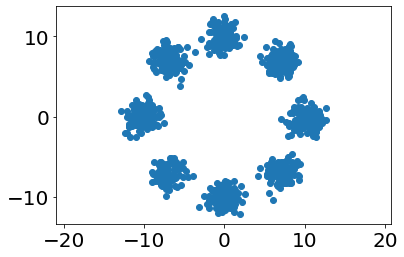

In [4]:
target_samples = target.get_samples(n=1000).cpu().numpy()
plt.scatter(target_samples[:, 0], target_samples[:, 1])
plt.axis('equal');

#### Common setup

In [5]:
## Here we fix K
args.n_steps = args.K # how many samples to use
args.n_warmup = 0 # num of first samples to refuse

args.n_chains = 10 # how many chains to model
args.data_dim = 2
args.z_dim = 2
args.train_batch_size = 500
args.early_stopping_tolerance = 1000

limit = 100

In [6]:
vanilla_kernel = HMC_vanilla(args)

## Vanilla HMC

In [7]:
q_new = args.std_normal.sample((args.n_chains, args.data_dim))
p_new = args.std_normal.sample((args.n_chains, args.data_dim))
        
print("Now we are running warmup!")
iterator = tqdm(range(args.n_warmup))
for i in iterator:
    q_new, p_new, _, _, a, _ = vanilla_kernel.make_transition(q_old=q_new, p_old=p_new, target_distr=target)
iterator.close()
    
samples_vanilla = torch.empty((args.n_steps, args.n_chains, args.data_dim), device=args.device, dtype=args.torchType)

print("Now we are sampling!")
iterator = tqdm(range(args.n_steps))
for i in iterator:
    q_new, p_new, _, _, a, _ = vanilla_kernel.make_transition(q_old=q_new, p_old=p_new, target_distr=target)
    samples_vanilla[i] = q_new
iterator.close()

0it [00:00, ?it/s]
100%|██████████| 5/5 [00:00<00:00, 91.87it/s]

Now we are running warmup!
Now we are sampling!


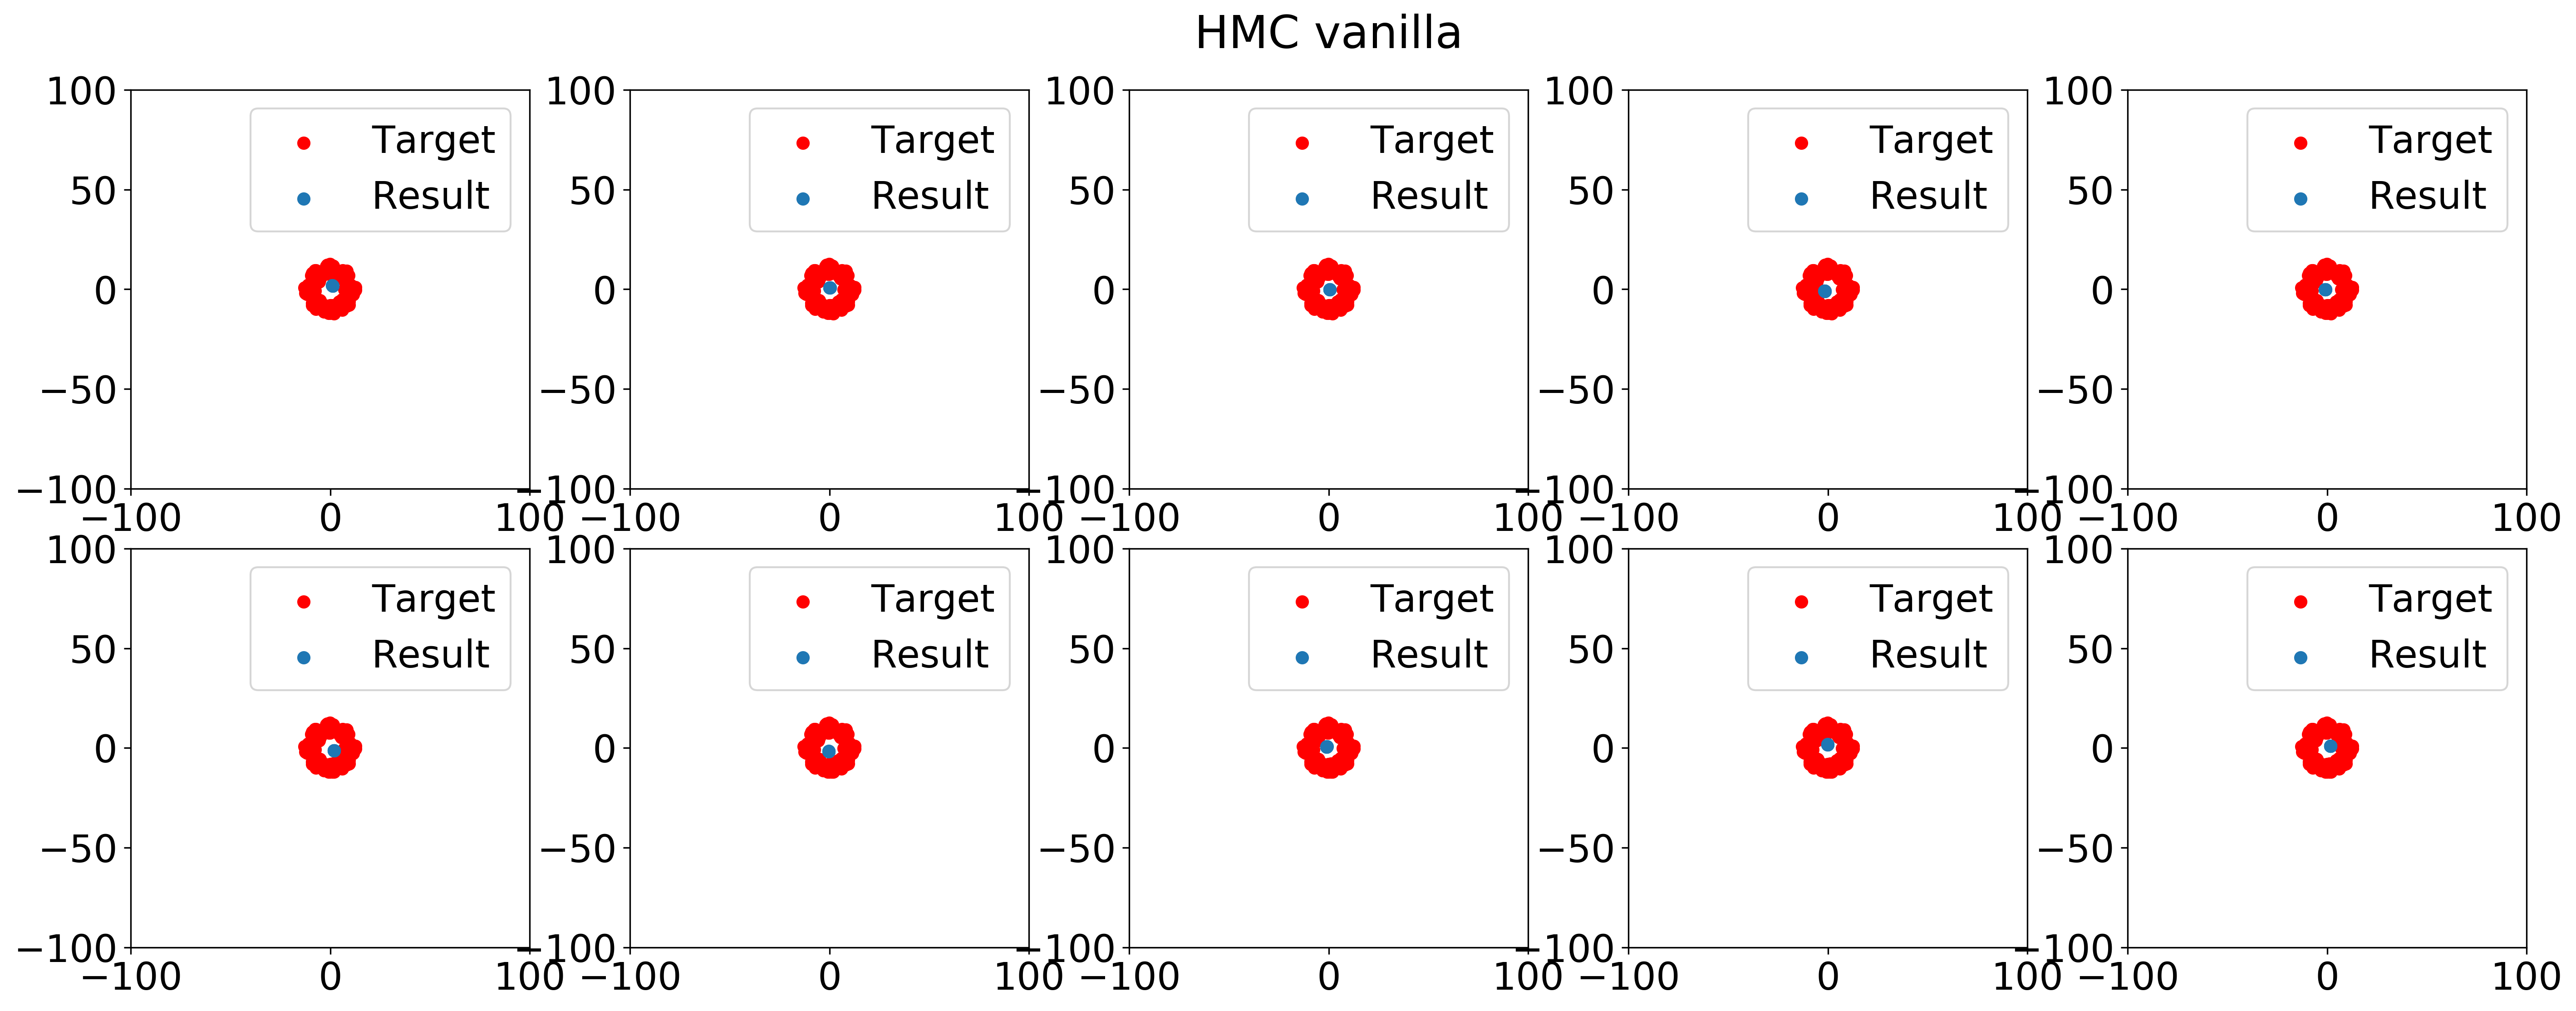

In [8]:
fig, ax = plt.subplots(nrows=args.n_chains // 5, ncols=5, figsize=(18, 7), dpi=300)
plt.suptitle('HMC vanilla')
for chain_num in range(args.n_chains):
    ax[chain_num // 5, chain_num % 5].scatter(target_samples[:, 0], target_samples[:, 1], c='r', label='Target')
    ax[chain_num // 5, chain_num % 5].scatter(samples_vanilla[:, chain_num, 0].cpu(), samples_vanilla[:, chain_num, 1].cpu(), label='Result')
    ax[chain_num // 5, chain_num % 5].set_xlim(-limit, limit)
    ax[chain_num // 5, chain_num % 5].set_ylim(-limit, limit)
    ax[chain_num // 5, chain_num % 5].set_aspect('equal')
    ax[chain_num // 5, chain_num % 5].legend()
plt.tight_layout();
plt.subplots_adjust(left=0., right=1., bottom=0., top=0.9, wspace=0.1, hspace=0.15)

100%|██████████| 5/5 [00:00<00:00, 85.79it/s]


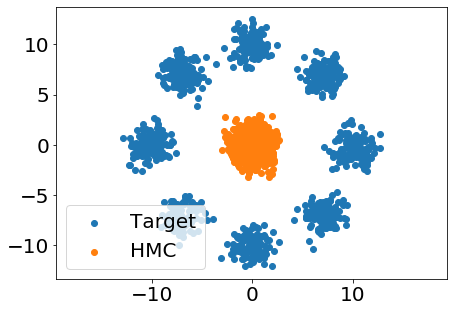

In [9]:
q_new = args.std_normal.sample((target_samples.shape[0], args.z_dim))
p_new = args.std_normal.sample((target_samples.shape[0], args.z_dim))

iterator = tqdm(range(args.n_steps))
for i in iterator:
    q_new, p_new, _, _, a, _ = vanilla_kernel.make_transition(q_old=q_new, p_old=p_new, target_distr=target)
iterator.close()

plt.figure(figsize=(7, 5))
plt.scatter(target_samples[:, 0], target_samples[:, 1], label='Target')
plt.scatter(q_new.cpu().detach().numpy()[:, 0], q_new.cpu().detach().numpy()[:, 1], label='HMC')
plt.legend()
plt.axis('equal');

In [10]:
# plt.figure(figsize=(15, 10), dpi=300)
# plt.scatter(target_samples[:, 0], target_samples[:, 1], label='Target', c='r')
# plt.plot(samples_vanilla[:, chain_num, 0].cpu(), samples_vanilla[:, chain_num, 1].cpu(), label='Result')
# plt.scatter(samples_vanilla[0, chain_num, 0].cpu(), samples_vanilla[0, chain_num, 1].cpu(), label='Starting point', c='k', s=200)
# plt.legend()
# plt.tight_layout()
# plt.savefig('./mcmc_Example.png', format='png')

In [12]:
# from pyro.infer import MCMC, NUTS

# def energy(z):
#     z = z['points']
#     return -target.get_logdensity(z)
# kernel = NUTS(potential_fn=energy)
# init_samples = torch.cat([chain[None] for chain in args.locs])

# init_params = {'points': init_samples}
# mcmc = MCMC(kernel=kernel, num_samples=2,
#             initial_params=init_params,
#             num_chains=8, warmup_steps=0, disable_progbar=True)
# mcmc.run()

# q_new = mcmc.get_samples(group_by_chain=True)["points"].squeeze()

## Hoffman HMC

In [11]:
##### Minimize KL first

mu_init_hoff = nn.Parameter(torch.zeros(args.data_dim, device=args.device, dtype=args.torchType))
sigma_init_hoff = nn.Parameter(torch.ones(args.data_dim, device=args.device, dtype=args.torchType))
optimizer = torch.optim.Adam(params=[mu_init_hoff, sigma_init_hoff], lr=args.learning_rate)

init_distr = torch.distributions.Normal(loc=mu_init_hoff, scale=nn.functional.softplus(sigma_init_hoff))
for i in tqdm(range(20000)):
#     pdb.set_trace()
    u_init =  args.std_normal.sample((500,args.data_dim ))
    q_init = mu_init_hoff + nn.functional.softplus(sigma_init_hoff) * u_init

    current_kl = args.std_normal.log_prob(u_init).sum(1) - torch.sum(nn.functional.softplus(sigma_init_hoff).log()) - target.get_logdensity(z=q_init)
    torch.mean(current_kl).backward() ## minimize KL
    optimizer.step()
    optimizer.zero_grad()
    if i % 2000 == 0:
        print(current_kl.mean().cpu().detach().numpy())

  0%|          | 44/20000 [00:00<01:31, 219.09it/s]

35.365368


 10%|█         | 2024/20000 [00:08<01:19, 226.72it/s]

16.653242


 20%|██        | 4026/20000 [00:17<01:13, 217.65it/s]

8.989213


 30%|███       | 6025/20000 [00:27<01:03, 220.20it/s]

5.374874


 40%|████      | 8028/20000 [00:36<00:54, 219.50it/s]

2.1812673


 50%|█████     | 10034/20000 [00:45<00:45, 217.77it/s]

2.0798337


 60%|██████    | 12034/20000 [00:54<00:37, 211.58it/s]

2.0797405


 70%|███████   | 14047/20000 [01:03<00:26, 225.11it/s]

2.0795515


 80%|████████  | 16036/20000 [01:13<00:18, 215.58it/s]

2.0794175


 90%|█████████ | 18043/20000 [01:22<00:08, 222.99it/s]

2.0794313


100%|██████████| 20000/20000 [01:31<00:00, 218.48it/s]


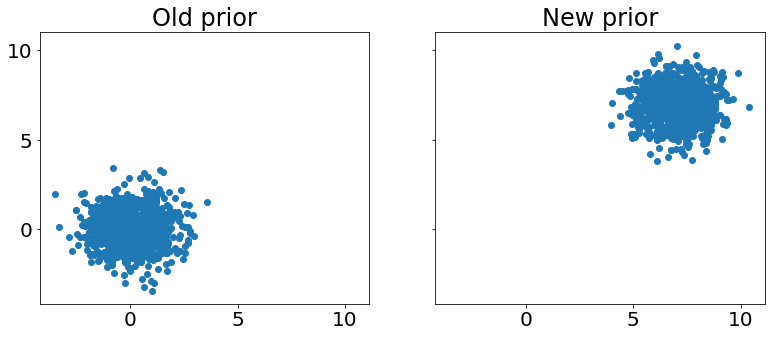

In [12]:
### Plot new prior
prior_old = args.std_normal.sample((1000, 2)).cpu().detach().numpy()

mu_init_hoff.requires_grad_(False)
sigma_init_hoff.requires_grad_(False)
prior_new = mu_init_hoff + args.std_normal.sample((1000, 2)) * nn.functional.softplus(sigma_init_hoff)
prior_new = prior_new.cpu().detach().numpy()

fig, ax = plt.subplots(ncols=2, figsize=(13, 5), sharex=True, sharey=True)
ax[0].scatter(prior_old[:, 0], prior_old[:, 1])
ax[1].scatter(prior_new[:, 0], prior_new[:, 1])
ax[0].set_title('Old prior')
ax[1].set_title('New prior');

In [13]:
### Then run HMC (without warmup) of length K

q_new = mu_init_hoff + args.std_normal.sample((args.n_chains, args.z_dim)) * nn.functional.softplus(sigma_init_hoff)
p_new = args.std_normal.sample((args.n_chains, args.z_dim))
        
print("Now we are running warmup!")
iterator = tqdm(range(args.n_warmup))
for i in iterator:
    q_new, p_new, _, _, a, _ = vanilla_kernel.make_transition(q_old=q_new, p_old=p_new, target_distr=target)
iterator.close()
    
samples_hoffman = torch.empty((args.n_steps, args.n_chains, args.z_dim), device=args.device, dtype=args.torchType)

print("Now we are sampling!")
iterator = tqdm(range(args.n_steps))
for i in iterator:
    q_new, p_new, _, _, a, _ = vanilla_kernel.make_transition(q_old=q_new, p_old=p_new, target_distr=target)
    samples_hoffman[i] = q_new
iterator.close()

0it [00:00, ?it/s]
100%|██████████| 5/5 [00:00<00:00, 75.19it/s]

Now we are running warmup!
Now we are sampling!


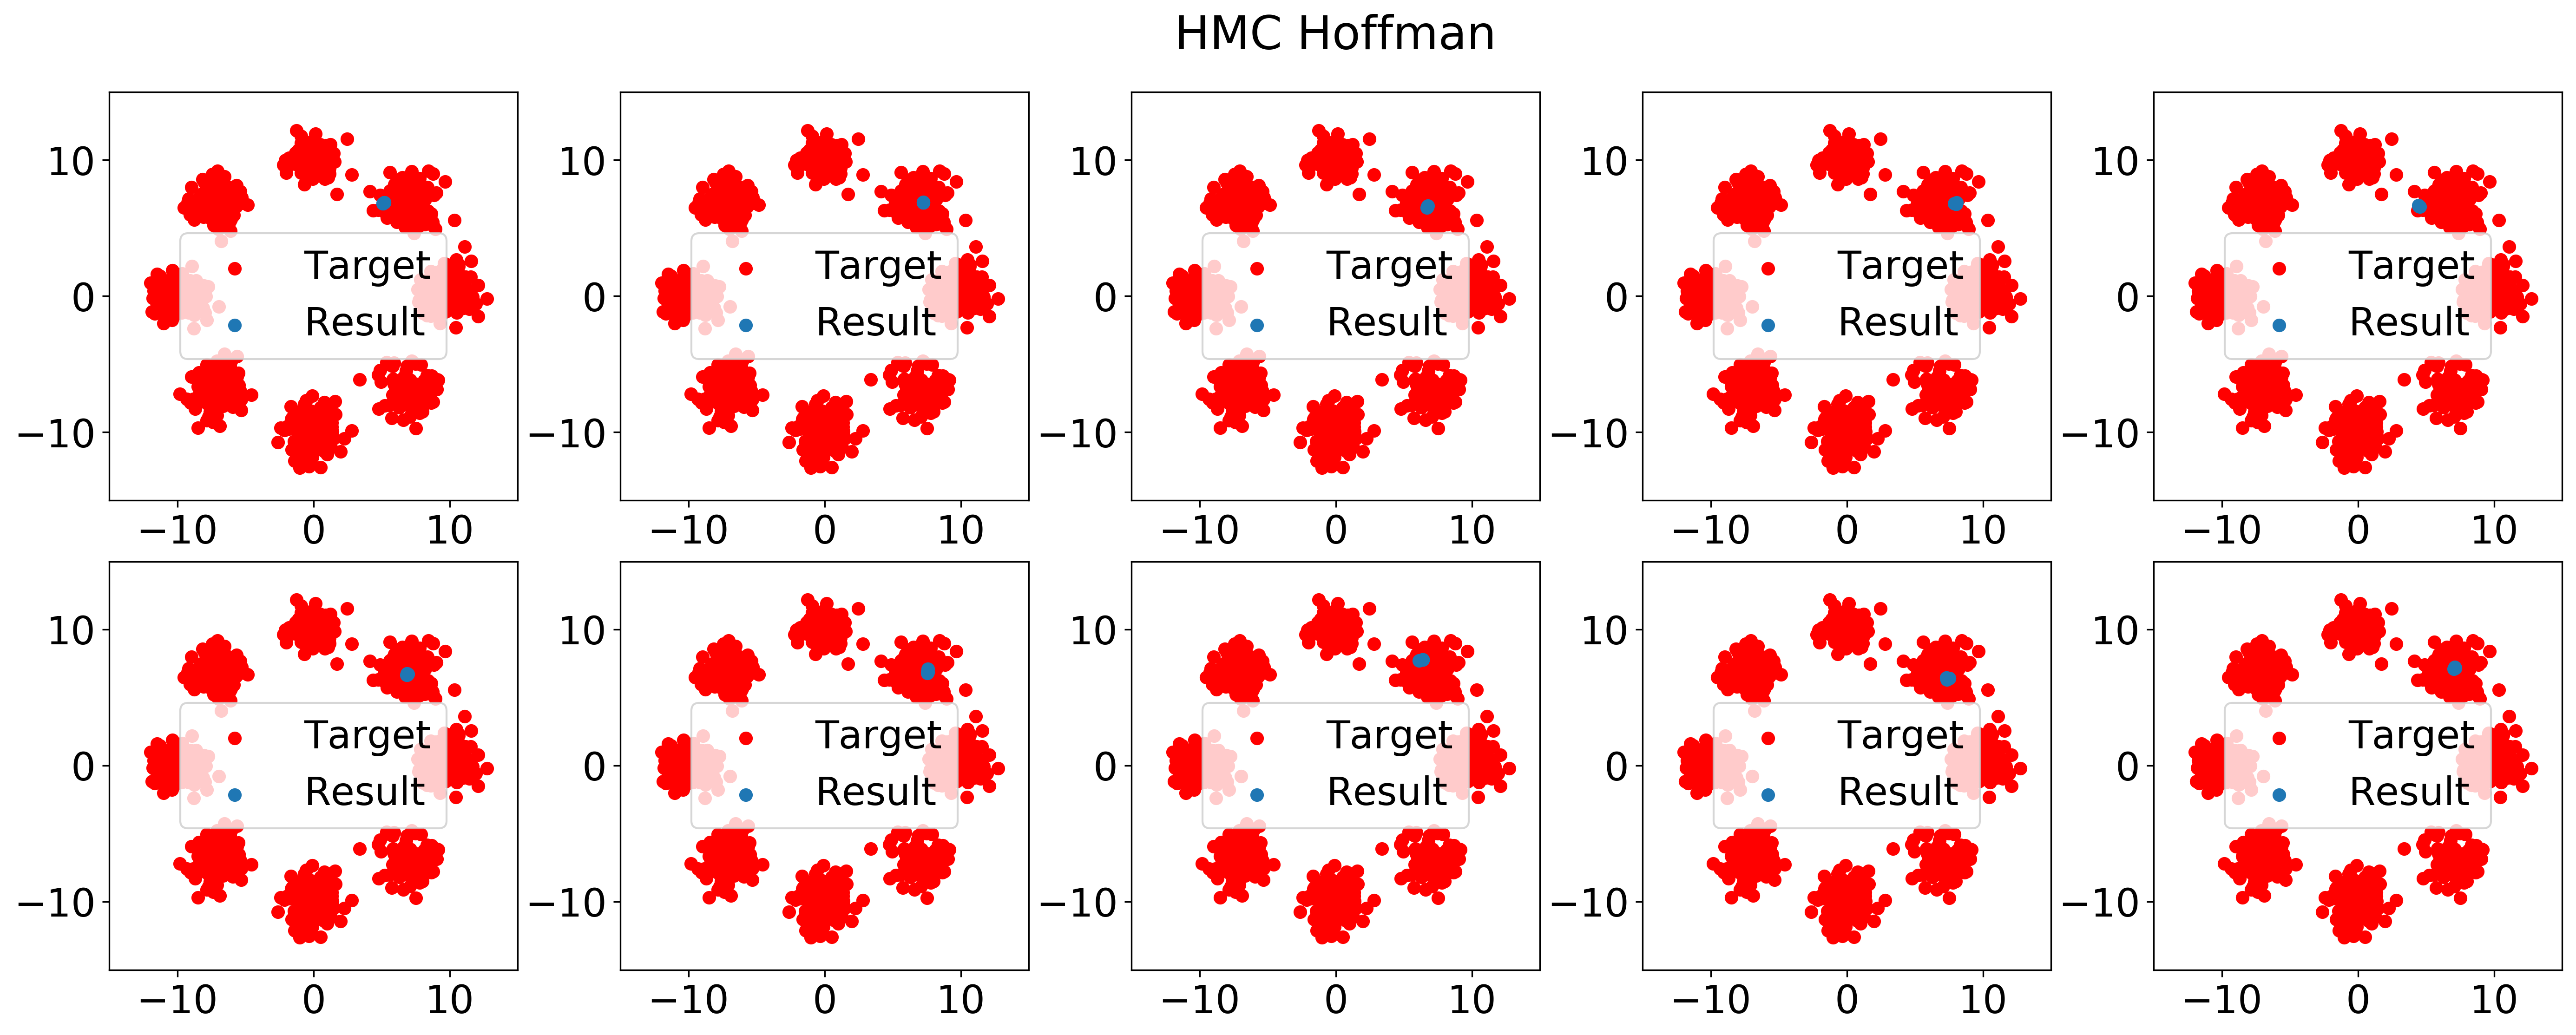

In [14]:
### Plot received chains

limit = 15
fig, ax = plt.subplots(nrows=args.n_chains // 5, ncols=5, figsize=(18, 7), dpi=300)
plt.suptitle('HMC Hoffman')
for chain_num in range(args.n_chains):
    ax[chain_num // 5, chain_num % 5].scatter(target_samples[:, 0], target_samples[:, 1], c='r', label='Target')
    ax[chain_num // 5, chain_num % 5].scatter(samples_hoffman[:, chain_num, 0].cpu(), samples_hoffman[:, chain_num, 1].cpu(), label='Result')
    ax[chain_num // 5, chain_num % 5].set_xlim(-limit, limit)
    ax[chain_num // 5, chain_num % 5].set_ylim(-limit, limit)
    ax[chain_num // 5, chain_num % 5].set_aspect('equal')
    ax[chain_num // 5, chain_num % 5].legend()
plt.tight_layout();
plt.subplots_adjust(left=0., right=1., bottom=0., top=0.9, wspace=0.1, hspace=0.15)

100%|██████████| 5/5 [00:00<00:00, 80.02it/s]


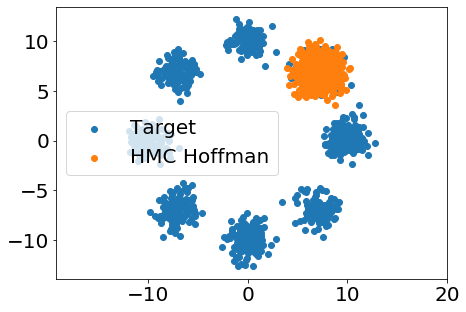

In [15]:
q_new = mu_init_hoff + args.std_normal.sample((target_samples.shape[0], args.z_dim)) * nn.functional.softplus(sigma_init_hoff)
p_new = args.std_normal.sample((target_samples.shape[0], args.z_dim))

iterator = tqdm(range(args.n_steps))
for i in iterator:
    q_new, p_new, _, _, a, _ = vanilla_kernel.make_transition(q_old=q_new, p_old=p_new, target_distr=target)
iterator.close()

plt.figure(figsize=(7, 5))
plt.scatter(target_samples[:, 0], target_samples[:, 1], label='Target')
plt.scatter(q_new.cpu().detach().numpy()[:, 0], q_new.cpu().detach().numpy()[:, 1], label='HMC Hoffman')
plt.legend()
plt.axis('equal');

In [16]:
from pyro.infer import MCMC, NUTS

def energy(z):
    z = z['points']
    return -target.get_logdensity(z)
kernel = NUTS(potential_fn=energy)
init_samples = mu_init_hoff + nn.functional.softplus(sigma_init_hoff) * args.std_normal.sample((1, args.z_dim))

init_params = {'points': init_samples}
mcmc = MCMC(kernel=kernel, num_samples=10000,
            initial_params=init_params,
            num_chains=init_samples.shape[0], warmup_steps=20000)
mcmc.run()

q_new = mcmc.get_samples(group_by_chain=True)["points"].squeeze()

Sample: 100%|██████████| 30000/30000 [08:26, 59.20it/s, step size=1.34e-01, acc. prob=0.918]


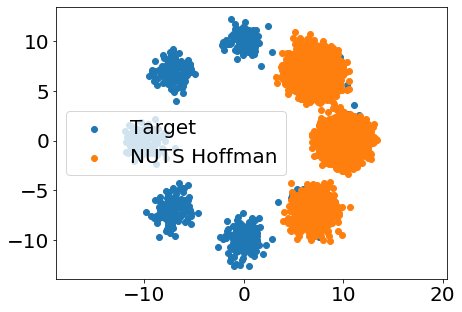

In [17]:
plt.figure(figsize=(7, 5))
plt.scatter(target_samples[:, 0], target_samples[:, 1], label='Target')
plt.scatter(q_new.cpu().detach().numpy()[:, 0], q_new.cpu().detach().numpy()[:, 1], label='NUTS Hoffman')
plt.legend()
plt.axis('equal');

In [19]:
# Wider prior

def energy(z):
    z = z['points']
    return -target.get_logdensity(z)
kernel = NUTS(potential_fn=energy)
init_samples = 5 * args.std_normal.sample((1, args.z_dim))

init_params = {'points': init_samples}
mcmc = MCMC(kernel=kernel, num_samples=10000,
            initial_params=init_params,
            num_chains=init_samples.shape[0], warmup_steps=20000)
mcmc.run()

q_new = mcmc.get_samples(group_by_chain=True)["points"].squeeze()

Sample: 100%|██████████| 30000/30000 [08:50, 56.57it/s, step size=1.36e-01, acc. prob=0.926]


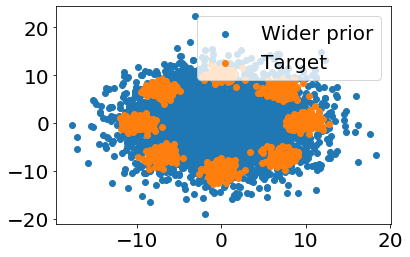

In [26]:
# New prior
new_prior = 5 * args.std_normal.sample((5000, args.z_dim))
plt.scatter(new_prior[:, 0].cpu().detach().numpy(), new_prior[:, 1].cpu().detach().numpy(), label='Wider prior')
plt.scatter(target_samples[:, 0], target_samples[:, 1], label='Target')
plt.legend();

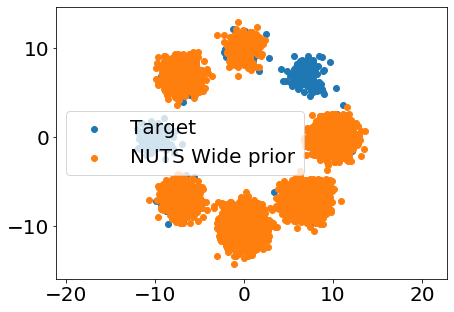

In [20]:
plt.figure(figsize=(7, 5))
plt.scatter(target_samples[:, 0], target_samples[:, 1], label='Target')
plt.scatter(q_new.cpu().detach().numpy()[:, 0], q_new.cpu().detach().numpy()[:, 1], label='NUTS Wide prior')
plt.legend()
plt.axis('equal');

## Neutra HMC

In [ ]:
##### Minimize KL first

from pyro.nn import AutoRegressiveNN, DenseNN
from pyro.distributions.transforms import NeuralAutoregressive, AffineAutoregressive, AffineCoupling

num_flows = 10
flow_type = 'IAF' # 'RNVP'

flow_list = []
for i in range(num_flows):
    if flow_type == 'IAF':
        one_arn = AutoRegressiveNN(args.data_dim, [2 * args.data_dim]).to(args.device)
        one_flow = AffineAutoregressive(one_arn)
    elif flow_type == 'RNVP':
        hypernet = DenseNN(input_dim=args.data_dim // 2, hidden_dims=[2 * args.data_dim, 2 * args.data_dim],
                param_dims=[args.data_dim - args.z_dim // 2, args.data_dim - args.data_dim // 2]).to(args.device)
        one_flow = AffineCoupling(args.data_dim // 2, hypernet).to(args.device)
    flow_list.append(one_flow)
flows = nn.ModuleList(flow_list)

optimizer = torch.optim.Adam(params=flows.parameters(), lr=args.learning_rate)

for i in tqdm(range(20000)):
#     pdb.set_trace()
    q_new = args.std_normal.sample((100, args.data_dim))
    u = q_new
    q_prev = q_new
    sum_log_jacobian = 0.
    for j in range(len(flows)):
        q_new = flows[j](q_prev)
        sum_log_jacobian += flows[j].log_abs_det_jacobian(q_prev, q_new)
        q_prev = q_new
        
    current_kl = args.std_normal.log_prob(u).sum(1) - sum_log_jacobian - target.get_logdensity(z=q_new)
    torch.mean(current_kl).backward() ## minimize KL
    optimizer.step()
    optimizer.zero_grad()
    if i % 2000 == 0:
        print(current_kl.mean().cpu().detach().numpy())

In [ ]:
### Plot new prior
prior = args.std_normal.sample((1000, 2))

for p in flows.parameters():
    p.requires_grad_(False)

prior_pushforward = prior
for i in range(len(flows)):
    prior_pushforward = flows[i](prior_pushforward)
prior_pushforward = prior_pushforward.cpu().detach().numpy()
prior = prior.cpu().detach().numpy()

fig, ax = plt.subplots(ncols=2, figsize=(13, 5), sharex=True, sharey=True)
ax[0].scatter(prior[:, 0], prior[:, 1])
ax[1].scatter(prior_pushforward[:, 0], prior_pushforward[:, 1])
ax[0].set_title('Prior')
ax[1].set_title('Prior pushforward');

In [ ]:
### Then run HMC (without warmup) of length K in warped space

q_new = args.std_normal.sample((args.n_chains, args.z_dim))
p_new = args.std_normal.sample((args.n_chains, args.z_dim))
        
print("Now we are running warmup!")
iterator = tqdm(range(args.n_warmup))
for i in iterator:
    q_new, p_new, _, _, a, _ = vanilla_kernel.make_transition(q_old=q_new, p_old=p_new, target_distr=target, flows=flows)
iterator.close()

samples_neutrahmc = torch.empty((args.n_steps, args.n_chains, args.z_dim), device=args.device, dtype=args.torchType)

print("Now we are sampling!")
iterator = tqdm(range(args.n_steps))
for i in iterator:
#     pdb.set_trace()
    q_new, p_new, _, _, a, _ = vanilla_kernel.make_transition(q_old=q_new, p_old=p_new, target_distr=target, flows=flows)
    ### Pushforward obtained samples in warped space to original space
    q_tr = q_new.detach()
    for j in range(len(flows)):
        q_tr = flows[j](q_tr)
    samples_neutrahmc[i] = q_tr
iterator.close()

In [ ]:
### Plot received chains

limit = 15
fig, ax = plt.subplots(nrows=args.n_chains // 5, ncols=5, figsize=(18, 7), dpi=300)
plt.suptitle('Neutra HMC')
for chain_num in range(args.n_chains):
    ax[chain_num // 5, chain_num % 5].scatter(target_samples[:, 0], target_samples[:, 1], c='r', label='Target')
    ax[chain_num // 5, chain_num % 5].scatter(samples_neutrahmc[:, chain_num, 0].cpu(), samples_neutrahmc[:, chain_num, 1].cpu(), label='Result')
    ax[chain_num // 5, chain_num % 5].set_xlim(-limit, limit)
    ax[chain_num // 5, chain_num % 5].set_ylim(-limit, limit)
    ax[chain_num // 5, chain_num % 5].set_aspect('equal')
    ax[chain_num // 5, chain_num % 5].legend()
plt.tight_layout();
plt.subplots_adjust(left=0., right=1., bottom=0., top=0.9, wspace=0.1, hspace=0.15)

In [ ]:
q_new = args.std_normal.sample((target_samples.shape[0], args.z_dim))
p_new = args.std_normal.sample((target_samples.shape[0], args.z_dim))

iterator = tqdm(range(args.n_steps))
for i in iterator:
    q_new, p_new, _, _, a, _ = vanilla_kernel.make_transition(q_old=q_new, p_old=p_new, target_distr=target, flows=flows)
iterator.close()
q_new = q_new.detach()
for j in range(len(flows)):
    q_new = flows[j](q_new)

plt.figure(figsize=(7, 5))
plt.scatter(target_samples[:, 0], target_samples[:, 1], label='Target')
plt.scatter(q_new.cpu().detach().numpy()[:, 0], q_new.cpu().detach().numpy()[:, 1], label='Neutra HMC')
plt.legend()
plt.axis('equal');

## Ours HMC (w/o reparametrization trick)

In [21]:
args.num_flows_prior = 0
prior_flow = None
get_prior = None

# def get_prior(args, inf_samples, prior_flow):
#     if args.nf_prior:
#         # Note, that here I am using T^+1 as T^-1
#         log_jac_flow = 0.
#         prev_v = inf_samples
#         for flow_num in range(args.num_flows_prior):
#             u = prior_flow[flow_num](prev_v)
#             log_jac_flow += prior_flow[flow_num].log_abs_det_jacobian(prev_v, u)
#             prev_v = u
#         prior = -1. / 2 * torch.sum(u * u, 1) + log_jac_flow
#     else:
#         prior = -1. / 2 * torch.sum(inf_samples * inf_samples, 1)
#     return prior

In [22]:
if args.learnable_reverse:
    reverse_kernel = Reverse_kernel_sampling(kwargs=args).to(args.device)
    reverse_params = reverse_kernel.parameters()
else:
    reverse_params = list([])

if args.amortize:
    transitions = HMC_our(kwargs=args).to(args.device)
    our_kernel_best_wo = HMC_our(kwargs=args).to(args.device)
else:
    transitions = nn.ModuleList([HMC_our(kwargs=args).to(args.device) for _ in range(args['K'])])
    our_kernel_best_wo = nn.ModuleList([HMC_our(kwargs=args).to(args.device) for _ in range(args.K)])
        
if args.fix_transition_params:
    for p in transitions.parameters():
        transitions.requires_grad_(False)
    
mu_init_wo = nn.Parameter(torch.zeros(args.data_dim, device=args.device, dtype=args.torchType))
sigma_init_wo = nn.Parameter(torch.ones(args.data_dim, device=args.device, dtype=args.torchType))

params = list(transitions.parameters()) + list(reverse_params) + [mu_init_wo, sigma_init_wo]

optimizer = torch.optim.Adam(params=params, lr=args.learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=200, factor=0.9)

  0%|          | 0/20000 [00:00<?, ?it/s]

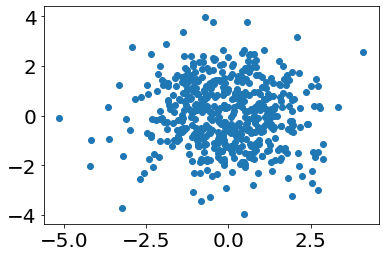

  0%|          | 3/20000 [00:00<44:20,  7.52it/s]

Current lr:  0.001
On batch number 0 ELBO is -42.28614044189453
On batch number 0 Best ELBO is -inf


  5%|▍         | 999/20000 [01:19<25:02, 12.64it/s]

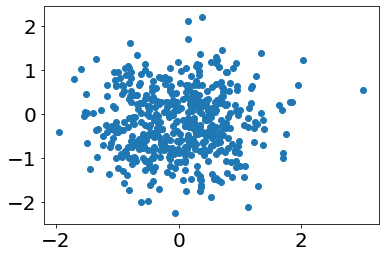

  5%|▌         | 1001/20000 [01:20<25:25, 12.45it/s]

Current lr:  0.0006561000000000001
On batch number 1000 ELBO is -49.396751403808594
On batch number 1000 Best ELBO is -41.64301681518555
Early stopping on 1002


In [23]:
# with torch.autograd.detect_anomaly():
print_info_ = 1000
torch_log_2 = torch.tensor(np.log(2.), device=args.device, dtype=args.torchType)
best_elbo = -float("inf")

x_lim = limit
y_lim = limit

def compute_loss(q_new, p_new, q_old, p_old, sum_log_alpha, sum_log_jac, all_directions, mu, sigma, u, get_prior, args, prior_flow):
    if args.learnable_reverse:
        log_r = reverse_kernel(z_fin=q_new, a=all_directions)
    else:
        log_r = -args.K * torch_log_2
    log_p = target.get_logdensity(z=q_new) + args.std_normal.log_prob(p_new).sum(1)

    sum_log_sigma = torch.sum(nn.functional.softplus(sigma).log())

    log_m = -sum_log_sigma + args.std_normal.log_prob(u).sum(1) + args.std_normal.log_prob(p_old).sum(1) - sum_log_jac + sum_log_alpha

    elbo_full = log_p + log_r - log_m
    grad_elbo = torch.mean(log_p + log_r + (sum_log_alpha - sum_log_sigma - 0.5 * torch.sum((q_old - mu)**2 / sigma**2, 1)) * (elbo_full.detach() - 1.))
    return elbo_full.detach().mean().item(), grad_elbo


iterator = tqdm(range(args.num_batches))
cur_tolerance = 0
for batch_num in iterator:
    plt.close()
    cond_vectors = [args.std_normal.sample((args.train_batch_size, args.z_dim)) for k in range(args.K)]

    # sample initial q and p
    u = args.std_normal.sample((args.train_batch_size, args.z_dim))
    q_old = mu_init_wo + u * nn.functional.softplus(sigma_init_wo)
    p_old = args.std_normal.sample((args.train_batch_size, args.z_dim))

    # prepare tensors for auxilary stuff
    sum_log_alpha = torch.zeros(q_old.shape[0], dtype=args.torchType, device=args.device) # for grad log alpha accumulation
    sum_log_jacobian = torch.zeros(q_old.shape[0], dtype=args.torchType, device=args.device) # for log_jacobian accumulation
    
    q_old = q_old.detach()
    p_old = p_old.detach()
    q = q_old
    p = p_old
    if (batch_num) % print_info_ == 0:
        array_z = []
        array_directions = []
        array_alpha = []
        array_prop = []

    if args.learnable_reverse:
        all_directions = torch.tensor([], device=args.device)
    else:
        all_directions = None

    # run training cycle
    for k in range(args.K):
        if args.amortize:
            q, p, log_jac, current_log_alphas, directions, q_prop = transitions.make_transition(q_old=q,
                                            p_old=p, k=cond_vectors[k], target_distr=target)
        else:
            q, p, log_jac, current_log_alphas, directions, q_prop = transitions[k].make_transition(q_old=q,
                                                        p_old=p, k=cond_vectors[k], target_distr=target) # sample a_i -- directions
#         if (batch_num) % print_info_ == 0:
#             print('On batch number {} and on k = {} we have for 0: {} and for +1: {}'.format(batch_num, k + 1,
#                                                         (directions==0.).to(float).mean(), (directions==1.).to(float).mean()))
#             print('Step size for {}-th transition is {}'.format(k, transitions[k].gamma.detach().exp()))
#             print('Alpha (ref) for {}-th transition is {}'.format(k, torch.sigmoid(transitions[k].alpha_logit.detach())))
        q = q.detach()
        p = p.detach()
        sum_log_alpha = sum_log_alpha + current_log_alphas
        sum_log_jacobian = sum_log_jacobian + log_jac
        if (batch_num) % print_info_ == 0:
            array_z.append(q.detach())
            array_directions.append(directions.detach())
            array_alpha.append(current_log_alphas.detach())
            array_prop.append(q_prop.detach())
        if args.learnable_reverse:
            all_directions = torch.cat([all_directions, directions.detach().view(-1, 1)], dim=1)
    elbo_full, grad_elbo = compute_loss(q_new=q, p_new=p, q_old=q_old, p_old=p_old,
                                        sum_log_jac=sum_log_jacobian,
                                            sum_log_alpha=sum_log_alpha, all_directions=all_directions, mu=mu_init_wo,
                                       sigma=sigma_init_wo, u=u, get_prior=get_prior, args=args, prior_flow=prior_flow)
    if (batch_num ) % print_info_ == 0:
        plt.scatter(q.cpu().detach()[:, 0], q.cpu().detach()[:, 1])
        plt.show();
        for param_group in optimizer.param_groups:
            current_lr = param_group['lr']
        print('Current lr: ', current_lr)
        print('On batch number {} ELBO is {}'.format(batch_num, elbo_full))
        print('On batch number {} Best ELBO is {}'.format(batch_num, best_elbo))

#         fig, ax = plt.subplots(ncols=args.K, figsize=(30, 10))
#         label = ['Same', 'Forward']
#         for kk in range(args.K):
#             ax[kk].scatter(array_prop[kk][:, 0].cpu().numpy(), array_prop[kk][:, 1].cpu().numpy(), color='r', label='Proposals')
#             for d in [0., 1.]:
#                 z_c = array_z[kk][array_directions[kk]==d]
#                 alpha_c = array_alpha[kk][array_directions[kk]==d].cpu().exp().numpy()
#                 color = np.zeros((z_c.shape[0], 4))
#                 color[:, 3] = alpha_c
#                 color[:, int(d + 1)] = 1.
#                 ax[kk].scatter(z_c[:, 0].cpu().numpy(), z_c[:, 1].cpu().numpy(), color=color, label=label[int(d)])
# #                 ax[kk].set_xlim((-x_lim, x_lim))
# #                 ax[kk].set_ylim((-y_lim, y_lim))L
#                 ax[kk].legend()
        plt.show();
    (-grad_elbo).backward()
    optimizer.step()
    optimizer.zero_grad()
    scheduler.step(elbo_full)

    if np.isnan(elbo_full):
        print('NAN appeared!')
        iterator.close()
        raise ValueError

    if elbo_full > best_elbo:
        best_elbo = elbo_full
        our_kernel_best_wo.load_state_dict(transitions.state_dict())
        cur_tolerance = 0
    else:
        cur_tolerance += 1
        if cur_tolerance >= args.early_stopping_tolerance:
            print('Early stopping on {}'.format(batch_num))
            iterator.close()
            break

In [24]:
# our_kernel_best = transitions
for p in our_kernel_best_wo.parameters():
    p.requires_grad_(False)
    
mu_init_wo.requires_grad_(False)
sigma_init_wo.requires_grad_(False)

Parameter containing:
tensor([-0.0170,  0.0166], device='cuda:1')

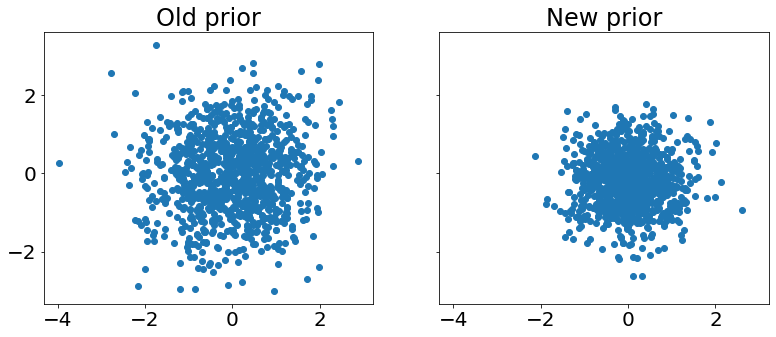

In [25]:
### Plot new prior
prior_old = args.std_normal.sample((1000, 2)).cpu().detach().numpy()

prior_new = mu_init_wo + args.std_normal.sample((1000, 2)) * nn.functional.softplus(sigma_init_wo)
prior_new = prior_new.cpu().detach().numpy()

fig, ax = plt.subplots(ncols=2, figsize=(13, 5), sharex=True, sharey=True)
ax[0].scatter(prior_old[:, 0], prior_old[:, 1])
ax[1].scatter(prior_new[:, 0], prior_new[:, 1])
ax[0].set_title('Old prior')
ax[1].set_title('New prior');

In [26]:
# n_samples = 10000
n_chains = 50
repetitions = 1

init_q = mu_init_wo + args.std_normal.sample((n_chains, args.z_dim)).requires_grad_(True) * nn.functional.softplus(sigma_init_wo)
q = init_q
our_samples = []
# our_samples.append(q.cpu().detach().numpy())

# init_p = args.std_normal.sample((n_samples, args.z_dim))
# p = init_p

for rep in range(repetitions):
    init_p = args.std_normal.sample((n_chains, args.z_dim))
    p = init_p
    cond_vectors = [args.std_normal.sample(init_p.shape) for _ in range(args.K)]
    for k in range(args.K):
        if args.amortize:
            q, p, _, _, _, _ = our_kernel_best_wo.make_transition(q_old=q,
                                            p_old=p, k=cond_vectors[k], target_distr=target) # sample a_i -- directions
        else:
            q, p, _, _, _, _ = our_kernel_best_wo[k].make_transition(q_old=q,
                                                        p_old=p, k=cond_vectors[k], target_distr=target) # sample a_i -- directions
        our_samples.append(q.cpu().detach().numpy())

In [27]:
our_samples = np.array(our_samples)

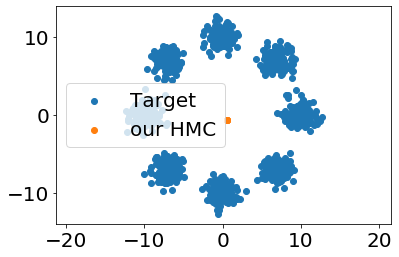

In [28]:
chain_ind = 11


plt.scatter(target_samples[:, 0], target_samples[:, 1], label='Target')
plt.scatter(our_samples[:, chain_ind, 0], our_samples[:, chain_ind, 1], label='our HMC')
# plt.xlim((-4, 4))
# plt.ylim((-4, 4))
plt.axis('equal')
plt.legend();


100%|██████████| 5/5 [00:00<00:00, 77.00it/s]


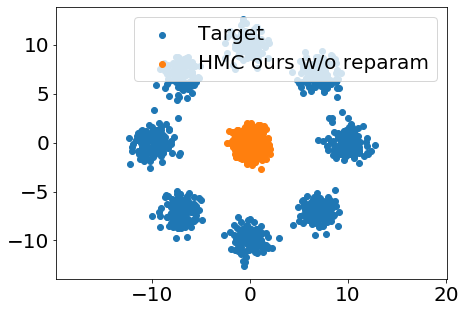

In [29]:
q_new = mu_init_wo + args.std_normal.sample((target_samples.shape[0], args.z_dim)) * nn.functional.softplus(sigma_init_wo)
p_new = args.std_normal.sample((target_samples.shape[0], args.z_dim))

iterator = tqdm(range(args.n_steps))

for i in iterator:
    cond_vectors = [args.std_normal.sample(p_new.shape) for k in range(args.K)]
    if args.amortize:
        q_new, p_new, _, _, a, _ = our_kernel_best_wo.make_transition(q_old=q_new, p_old=p_new, target_distr=target, k=cond_vectors[i % args.K])
    else:
        q_new, p_new, _, _, a, _ = our_kernel_best_wo[i % args.K].make_transition(q_old=q_new, p_old=p_new, target_distr=target, k=cond_vectors[i % args.K])
iterator.close()

plt.figure(figsize=(7, 5))
plt.scatter(target_samples[:, 0], target_samples[:, 1], label='Target')
plt.scatter(q_new.cpu().detach().numpy()[:, 0], q_new.cpu().detach().numpy()[:, 1], label='HMC ours w/o reparam')
plt.legend()
plt.axis('equal');

## Ours HMC (with reparametrization trick)

In [30]:
if args.learnable_reverse:
    reverse_kernel = Reverse_kernel_sampling(kwargs=args).to(args.device)
    reverse_params = reverse_kernel.parameters()
else:
    reverse_params = list([])

if args.amortize:
    transitions = HMC_our(kwargs=args).to(args.device)
    our_kernel_best_w = HMC_our(kwargs=args).to(args.device)
else:
    transitions = nn.ModuleList([HMC_our(kwargs=args).to(args.device) for _ in range(args['K'])])
    our_kernel_best_w = nn.ModuleList([HMC_our(kwargs=args).to(args.device) for _ in range(args.K)])
        
if args.fix_transition_params:
    for p in transitions.parameters():
        transitions.requires_grad_(False)
    
mu_init_w = nn.Parameter(torch.zeros(args.data_dim, device=args.device, dtype=args.torchType))
sigma_init_w = nn.Parameter(torch.ones(args.data_dim, device=args.device, dtype=args.torchType))

params = list(transitions.parameters()) + list(reverse_params) + [mu_init_w, sigma_init_w]

optimizer = torch.optim.Adam(params=params, lr=args.learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=200, factor=0.9)

  0%|          | 0/20000 [00:00<?, ?it/s]

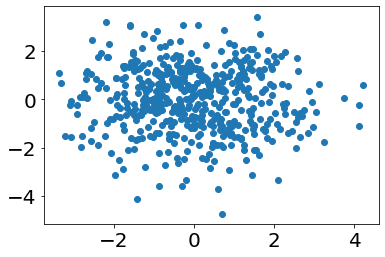

  0%|          | 3/20000 [00:00<46:52,  7.11it/s]

Current lr:  0.001
On batch number 0 ELBO is -41.78005599975586
On batch number 0 Best ELBO is -inf


  5%|▍         | 999/20000 [01:29<28:24, 11.15it/s]

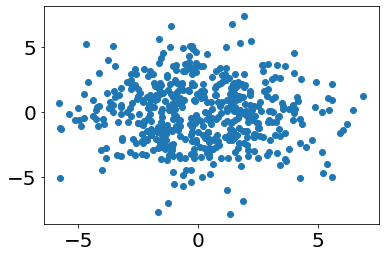

  5%|▌         | 1003/20000 [01:30<31:26, 10.07it/s]

Current lr:  0.001
On batch number 1000 ELBO is -28.383052825927734
On batch number 1000 Best ELBO is -28.407684326171875


 10%|▉         | 1999/20000 [03:00<27:15, 11.01it/s]

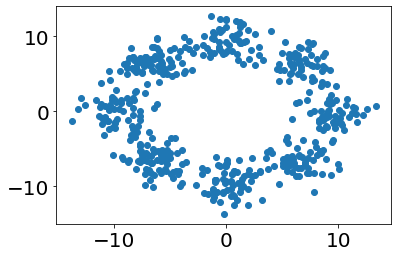

 10%|█         | 2001/20000 [03:00<30:32,  9.82it/s]

Current lr:  0.001
On batch number 2000 ELBO is -5.701030731201172
On batch number 2000 Best ELBO is -5.377228736877441


 15%|█▍        | 2999/20000 [04:30<25:26, 11.13it/s]

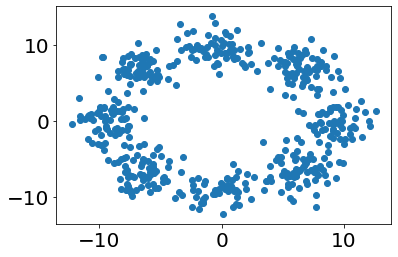

 15%|█▌        | 3003/20000 [04:31<27:30, 10.30it/s]

Current lr:  0.0009000000000000001
On batch number 3000 ELBO is -5.11551570892334
On batch number 3000 Best ELBO is -5.037125110626221


 20%|█▉        | 3999/20000 [06:01<23:54, 11.16it/s]

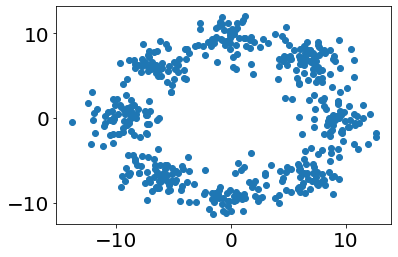

 20%|██        | 4001/20000 [06:01<26:47,  9.95it/s]

Current lr:  0.00059049
On batch number 4000 ELBO is -5.110972881317139
On batch number 4000 Best ELBO is -4.7709808349609375


 25%|██▍       | 4999/20000 [07:30<22:23, 11.17it/s]

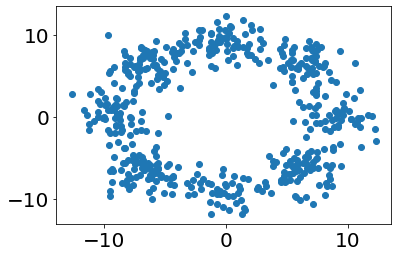

 25%|██▌       | 5003/20000 [07:31<24:06, 10.37it/s]

Current lr:  0.000531441
On batch number 5000 ELBO is -4.971755027770996
On batch number 5000 Best ELBO is -4.431324481964111


 30%|██▉       | 5999/20000 [09:01<21:02, 11.09it/s]

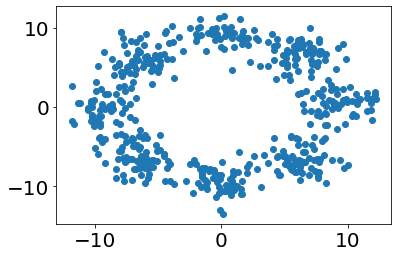

 30%|███       | 6003/20000 [09:01<22:40, 10.29it/s]

Current lr:  0.000387420489
On batch number 6000 ELBO is -4.663366317749023
On batch number 6000 Best ELBO is -4.1737141609191895


 35%|███▍      | 6999/20000 [10:31<19:40, 11.02it/s]

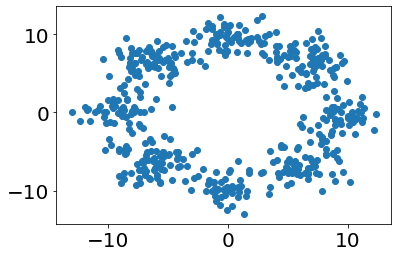

 35%|███▌      | 7001/20000 [10:31<22:36,  9.58it/s]

Current lr:  0.00028242953648100003
On batch number 7000 ELBO is -4.441079139709473
On batch number 7000 Best ELBO is -3.9124860763549805


 40%|███▉      | 7999/20000 [12:01<18:06, 11.05it/s]

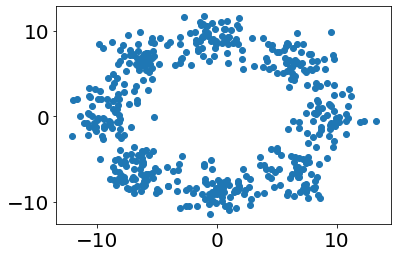

 40%|████      | 8001/20000 [12:01<20:18,  9.85it/s]

Current lr:  0.00018530201888518417
On batch number 8000 ELBO is -4.321865081787109
On batch number 8000 Best ELBO is -3.701167583465576


 45%|████▍     | 8999/20000 [13:32<16:34, 11.07it/s]

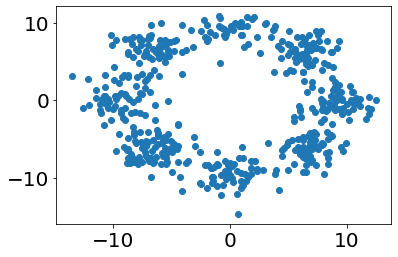

 45%|████▌     | 9001/20000 [13:32<19:35,  9.36it/s]

Current lr:  0.00012157665459056936
On batch number 9000 ELBO is -4.076290130615234
On batch number 9000 Best ELBO is -3.6978659629821777


 50%|████▉     | 9999/20000 [15:02<14:58, 11.13it/s]

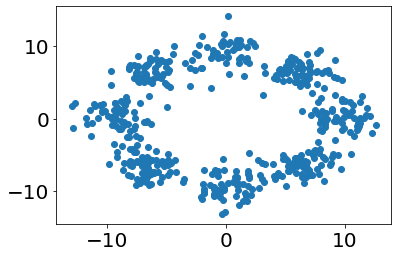

 50%|█████     | 10003/20000 [15:02<16:09, 10.31it/s]

Current lr:  9.847709021836118e-05
On batch number 10000 ELBO is -3.901718854904175
On batch number 10000 Best ELBO is -3.5168914794921875


 55%|█████▍    | 10999/20000 [16:32<13:26, 11.16it/s]

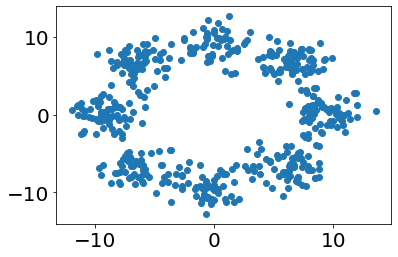

 55%|█████▌    | 11001/20000 [16:32<15:04,  9.95it/s]

Current lr:  7.17897987691853e-05
On batch number 11000 ELBO is -3.7926793098449707
On batch number 11000 Best ELBO is -3.431002616882324


 59%|█████▉    | 11895/20000 [17:53<12:11, 11.08it/s]

Early stopping on 11896


In [31]:
# with torch.autograd.detect_anomaly():
print_info_ = 1000
torch_log_2 = torch.tensor(np.log(2.), device=args.device, dtype=args.torchType)
best_elbo = -float("inf")

x_lim = limit
y_lim = limit

def compute_loss(q_new, p_new, u, p_old, sum_log_alpha, sum_log_jac, all_directions=None, sum_log_sigma=None):
    if args.learnable_reverse:
        log_r = reverse_kernel(z_fin=q_new.detach(), a=all_directions)
    else:
        log_r = -args.K * torch_log_2
    log_p = target.get_logdensity(z=q_new) + args.std_normal.log_prob(p_new).sum(1)
    log_m = -sum_log_sigma + args.std_normal.log_prob(u).sum(1) + args.std_normal.log_prob(p_old).sum(1) - sum_log_jac + sum_log_alpha
    elbo_full = log_p + log_r - log_m
    grad_elbo = torch.mean(elbo_full + elbo_full.detach() * sum_log_alpha)
    return elbo_full.detach().mean().item(), grad_elbo


iterator = tqdm(range(args.num_batches))
cur_tolerance = 0
for batch_num in iterator:
    plt.close()
    cond_vectors = [args.std_normal.sample((args.train_batch_size, args.z_dim)) for k in range(args.K)]

    # sample initial q and p
    u = args.std_normal.sample((args.train_batch_size, args.z_dim))
    q_old = mu_init_w + u * nn.functional.softplus(sigma_init_w)
    p_old = args.std_normal.sample((args.train_batch_size, args.z_dim))
    sum_log_sigma = torch.sum(nn.functional.softplus(sigma_init_w).log())

    # prepare tensors for auxilary stuff
    sum_log_alpha = torch.zeros(q_old.shape[0], dtype=args.torchType, device=args.device) # for grad log alpha accumulation
    sum_log_jacobian = torch.zeros(q_old.shape[0], dtype=args.torchType, device=args.device) # for log_jacobian accumulation

    q = q_old
    p = p_old
    if (batch_num) % print_info_ == 0:
        array_z = []
        array_directions = []
        array_alpha = []
        array_prop = []

    if args.learnable_reverse:
        all_directions = torch.tensor([], device=args.device)
    else:
        all_directions = None
        
     # run training cycle
    for k in range(args.K):
        if args.amortize:
            q, p, log_jac, current_log_alphas, directions, q_prop = transitions.make_transition(q_old=q,
                                            p_old=p, k=cond_vectors[k], target_distr=target)
        else:
            q, p, log_jac, current_log_alphas, directions, q_prop = transitions[k].make_transition(q_old=q,
                                                        p_old=p, k=cond_vectors[k], target_distr=target) # sample a_i -- directions
#         if (batch_num) % print_info_ == 0:
#             print('On batch number {} and on k = {} we have for 0: {} and for +1: {}'.format(batch_num, k + 1,
#                                                         (directions==0.).to(float).mean(), (directions==1.).to(float).mean()))
#             print('Step size for {}-th transition is {}'.format(k, transitions[k].gamma.detach().exp()))
#             print('Alpha (ref) for {}-th transition is {}'.format(k, torch.sigmoid(transitions[k].alpha_logit.detach())))
        sum_log_alpha = sum_log_alpha + current_log_alphas
        sum_log_jacobian = sum_log_jacobian + log_jac
        if (batch_num) % print_info_ == 0:
            array_z.append(q.detach())
            array_directions.append(directions.detach())
            array_alpha.append(current_log_alphas.detach())
            array_prop.append(q_prop.detach())
        if args.learnable_reverse:
            all_directions = torch.cat([all_directions, directions.detach().view(-1, 1)], dim=1)
    elbo_full, grad_elbo = compute_loss(q_new=q, p_new=p, u=u, p_old=p_old, sum_log_jac=sum_log_jacobian,
                                            sum_log_alpha=sum_log_alpha, all_directions=all_directions, sum_log_sigma=sum_log_sigma)
    if (batch_num ) % print_info_ == 0:
        plt.scatter(q.cpu().detach()[:, 0], q.cpu().detach()[:, 1])
        plt.show();
        for param_group in optimizer.param_groups:
            current_lr = param_group['lr']
        print('Current lr: ', current_lr)
        print('On batch number {} ELBO is {}'.format(batch_num, elbo_full))
        print('On batch number {} Best ELBO is {}'.format(batch_num, best_elbo))
#         fig, ax = plt.subplots(ncols=args.K, figsize=(30, 10))
#         label = ['Same', 'Forward']
#         for kk in range(args.K):
#             ax[kk].scatter(array_prop[kk][:, 0].cpu().numpy(), array_prop[kk][:, 1].cpu().numpy(), color='r', label='Proposals')
#             for d in [0., 1.]:
#                 z_c = array_z[kk][array_directions[kk]==d]
#                 alpha_c = array_alpha[kk][array_directions[kk]==d].cpu().exp().numpy()
#                 color = np.zeros((z_c.shape[0], 4))
#                 color[:, 3] = alpha_c
#                 color[:, int(d + 1)] = 1.
#                 ax[kk].scatter(z_c[:, 0].cpu().numpy(), z_c[:, 1].cpu().numpy(), color=color, label=label[int(d)])
# #                 ax[kk].set_xlim((-x_lim, x_lim))
# #                 ax[kk].set_ylim((-y_lim, y_lim))
#                 ax[kk].legend()
        plt.show();
    (-grad_elbo).backward()
    optimizer.step()
    optimizer.zero_grad()
    scheduler.step(elbo_full)

    if np.isnan(elbo_full):
        print('NAN appeared!')
        iterator.close()
        raise ValueError

    if elbo_full > best_elbo:
        best_elbo = elbo_full
        our_kernel_best_w.load_state_dict(transitions.state_dict())
        cur_tolerance = 0
    else:
        cur_tolerance += 1
        if cur_tolerance >= args.early_stopping_tolerance:
            print('Early stopping on {}'.format(batch_num))
            iterator.close()
            break

100%|██████████| 5/5 [00:00<00:00, 72.88it/s]


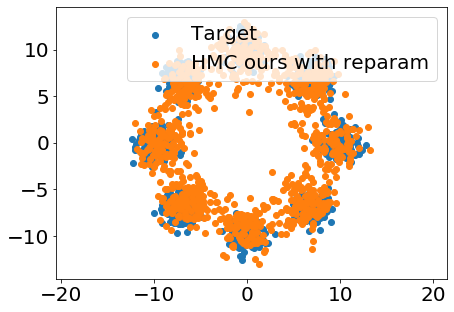

In [32]:
q_new = mu_init_w + args.std_normal.sample((target_samples.shape[0], args.z_dim)) * nn.functional.softplus(sigma_init_w)
p_new = args.std_normal.sample((target_samples.shape[0], args.z_dim))

iterator = tqdm(range(args.n_steps))

for i in iterator:
    cond_vectors = [args.std_normal.sample(p_new.shape) for k in range(args.K)]
    if args.amortize:
        q_new, p_new, _, _, a, _ = our_kernel_best_w.make_transition(q_old=q_new, p_old=p_new, target_distr=target, k=cond_vectors[i  % args.K])
    else:
        q_new, p_new, _, _, a, _ = our_kernel_best_w[i % args.K].make_transition(q_old=q_new, p_old=p_new, target_distr=target, k=cond_vectors[i  % args.K])
iterator.close()

plt.figure(figsize=(7, 5))
plt.scatter(target_samples[:, 0], target_samples[:, 1], label='Target')
plt.scatter(q_new.cpu().detach().numpy()[:, 0], q_new.cpu().detach().numpy()[:, 1], label='HMC ours with reparam')
plt.legend()
plt.axis('equal');

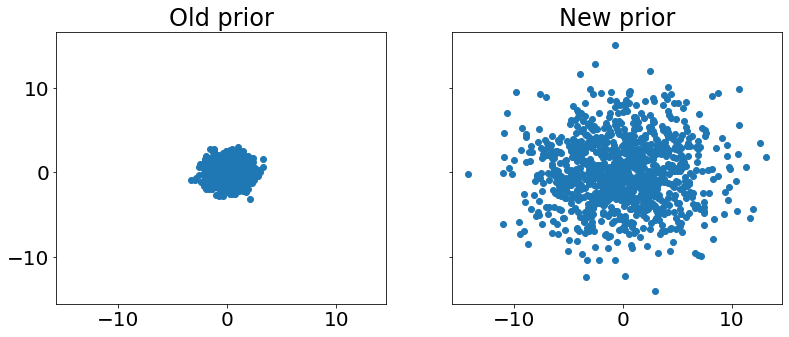

In [33]:
### Plot new prior
prior_old = args.std_normal.sample((1000, 2)).cpu().detach().numpy()

prior_new = mu_init_w + args.std_normal.sample((1000, 2)) * nn.functional.softplus(sigma_init_w)
prior_new = prior_new.cpu().detach().numpy()

fig, ax = plt.subplots(ncols=2, figsize=(13, 5), sharex=True, sharey=True)
ax[0].scatter(prior_old[:, 0], prior_old[:, 1])
ax[1].scatter(prior_new[:, 0], prior_new[:, 1])
ax[0].set_title('Old prior')
ax[1].set_title('New prior');

In [34]:
for p in our_kernel_best_w.parameters():
    p.requires_grad_(False)
    
mu_init_w.requires_grad_(False)
sigma_init_w.requires_grad_(False)

Parameter containing:
tensor([4.1288, 4.1434], device='cuda:1')

# All samples

100%|██████████| 5/5 [00:00<00:00, 76.32it/s]


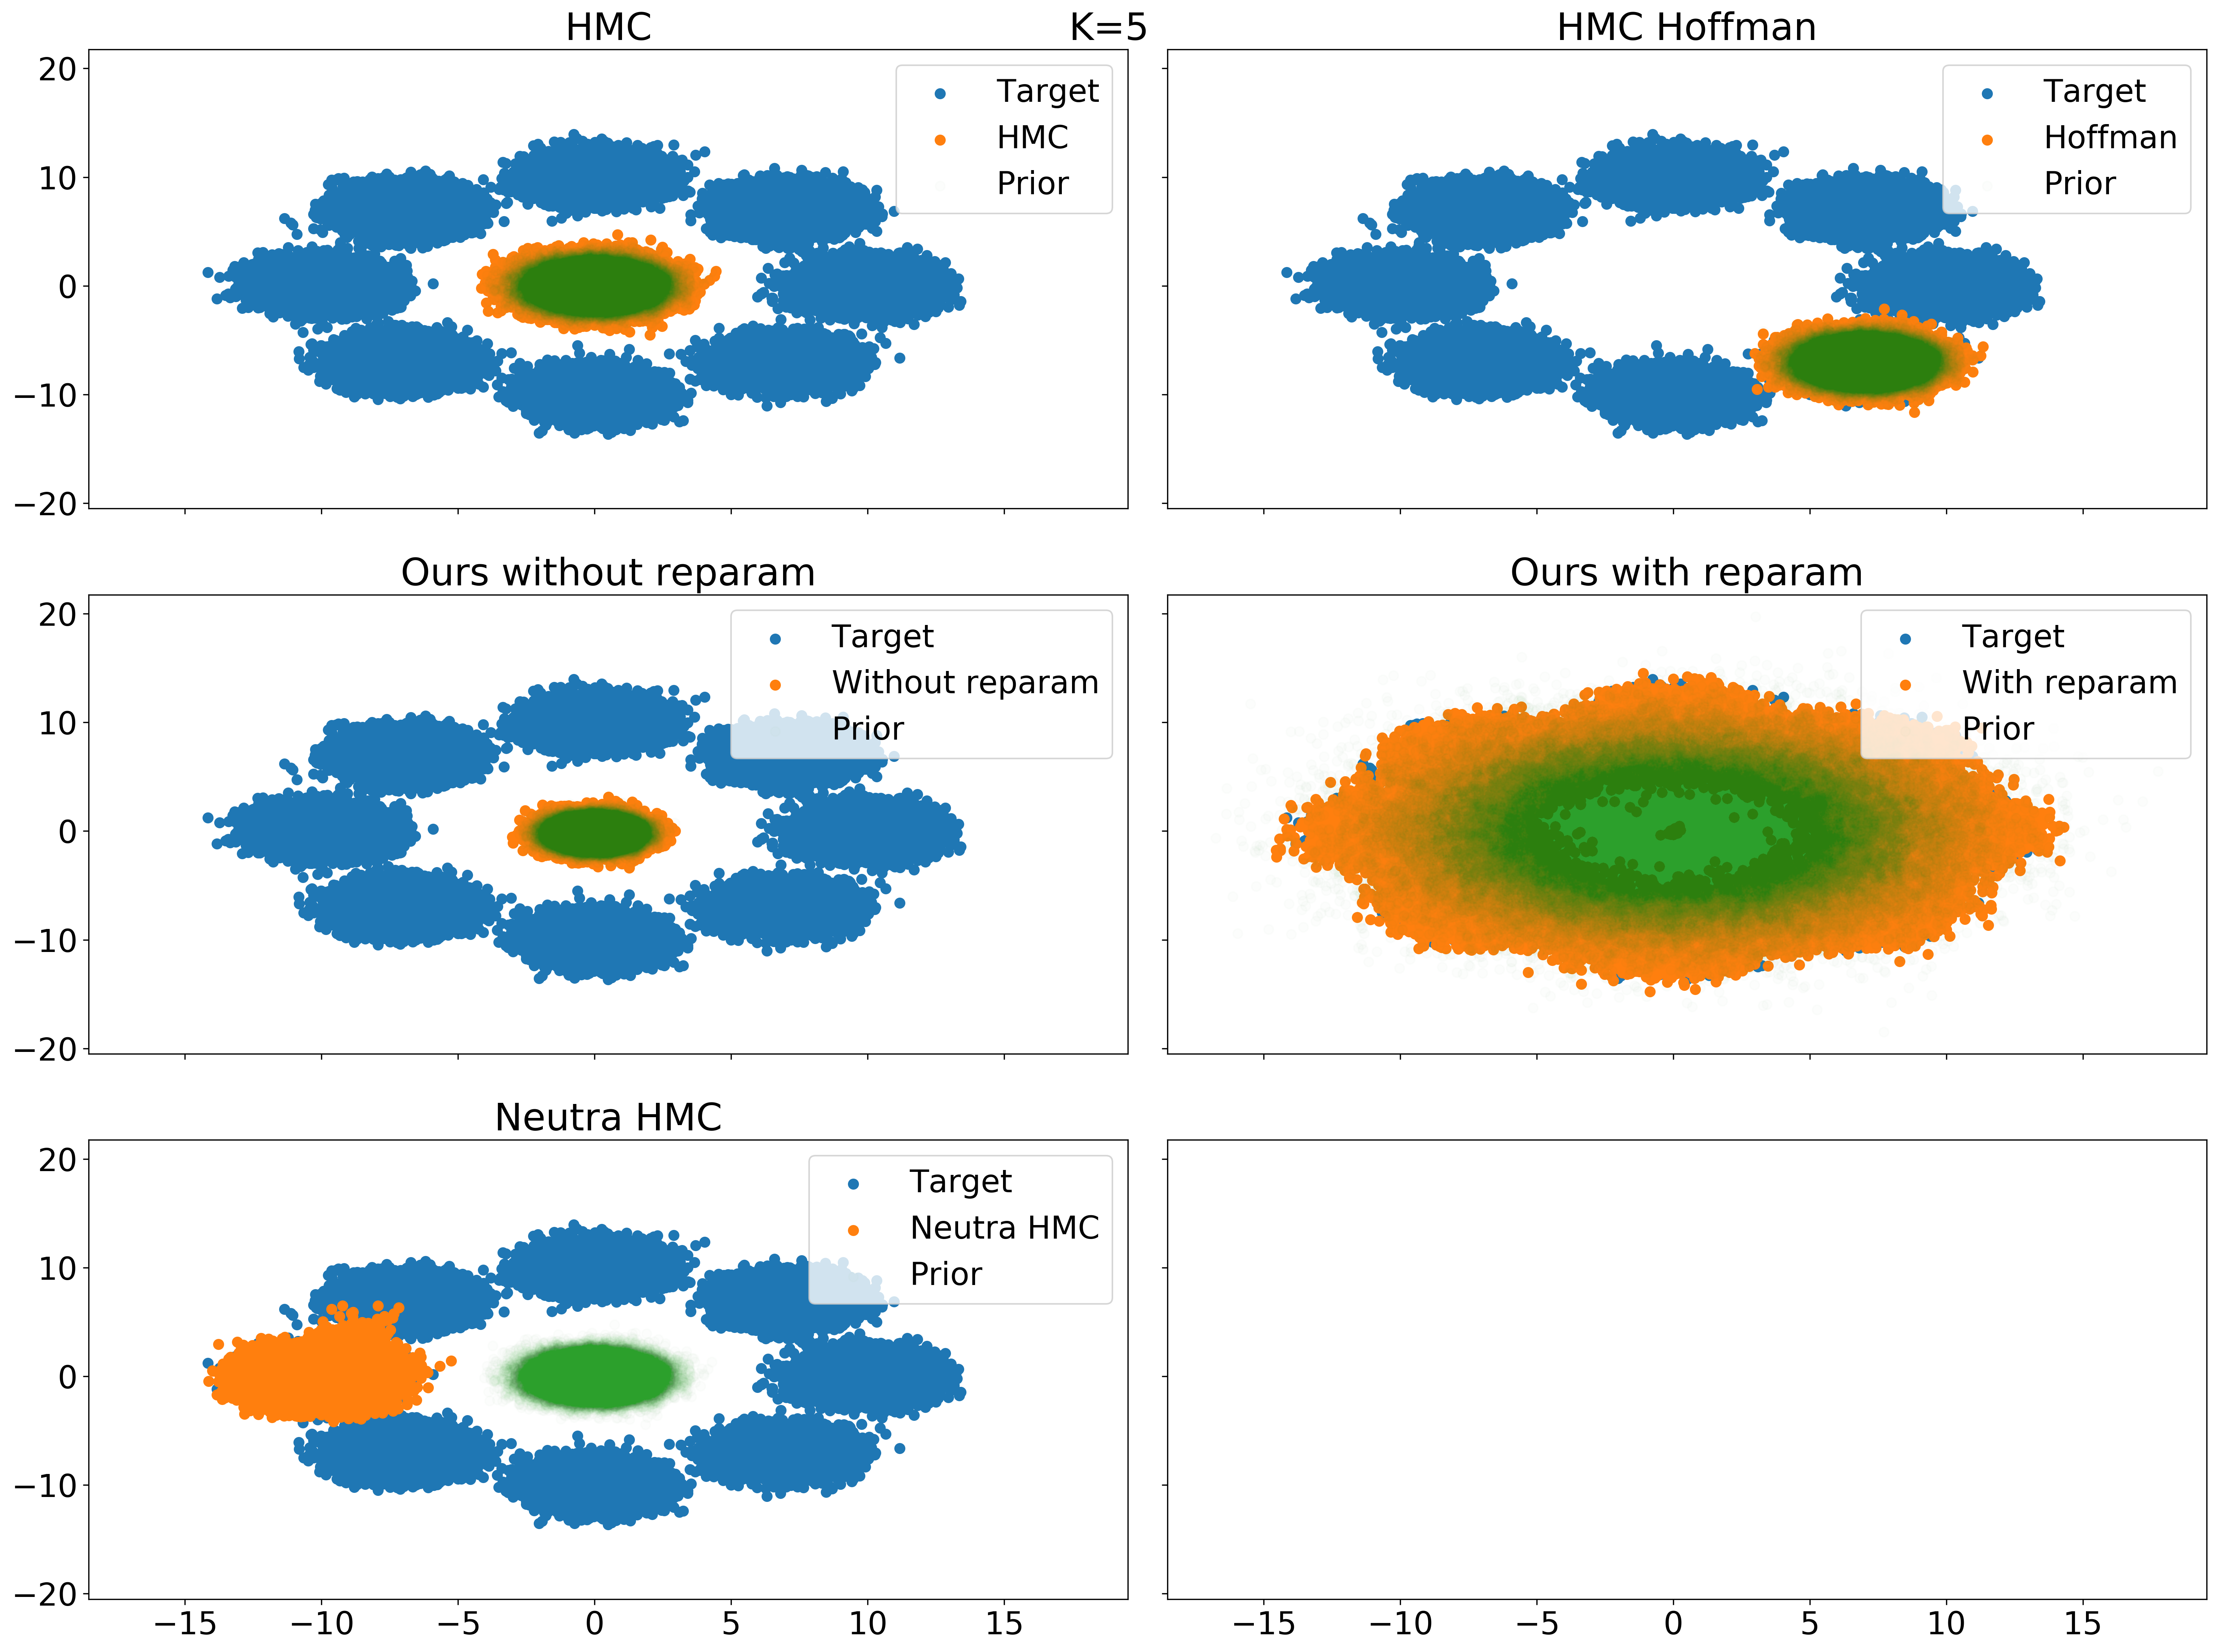

In [35]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(20, 15), dpi=300, sharex=True, sharey=True)

target_samples = target.get_samples(n=100000).cpu().numpy()
u = args.std_normal.sample((target_samples.shape[0], args.z_dim))

##### Vanilla HMC

q_new = u #args.std_normal.sample((target_samples.shape[0], args.z_dim))
p_new = args.std_normal.sample((target_samples.shape[0], args.z_dim))

iterator = tqdm(range(args.n_steps))
for i in iterator:
    q_new, p_new, _, _, a, _ = vanilla_kernel.make_transition(q_old=q_new, p_old=p_new, target_distr=target)
iterator.close()

samples_hmc = q_new.cpu().detach().numpy()

###### Hoffman HMC

q_new = mu_init_hoff + u * nn.functional.softplus(sigma_init_hoff)
p_new = args.std_normal.sample((target_samples.shape[0], args.z_dim))

iterator = tqdm(range(args.n_steps))
for i in iterator:
    q_new, p_new, _, _, a, _ = vanilla_kernel.make_transition(q_old=q_new, p_old=p_new, target_distr=target)
iterator.close()

samples_hoff = q_new.cpu().detach().numpy()


####### Neutra HMC

q_new = u
p_new = args.std_normal.sample((target_samples.shape[0], args.z_dim))

iterator = tqdm(range(args.n_steps))
for i in iterator:
    q_new, p_new, _, _, a, _ = vanilla_kernel.make_transition(q_old=q_new, p_old=p_new, target_distr=target, flows=flows)
iterator.close()

q_new = q_new.detach()
for j in range(len(flows)):
    q_new = flows[j](q_new)

samples_neutrahmc = q_new.cpu().detach().numpy()


###### Ours without reparam

q_new = mu_init_wo + u * nn.functional.softplus(sigma_init_wo)
p_new = args.std_normal.sample((target_samples.shape[0], args.z_dim))

iterator = tqdm(range(args.n_steps))
for i in iterator:
    cond_vectors = [args.std_normal.sample(p_new.shape) for k in range(args.K)]
    if args.amortize:
        q_new, p_new, _, _, a, _ = our_kernel_best_wo.make_transition(q_old=q_new, p_old=p_new, target_distr=target, k=cond_vectors[i])
    else:
        q_new, p_new, _, _, a, _ = our_kernel_best_wo[i].make_transition(q_old=q_new, p_old=p_new, target_distr=target, k=cond_vectors[i])
iterator.close()

samples_wo = q_new.cpu().detach().numpy()

###### Ours with reparam

q_new = mu_init_w + u * nn.functional.softplus(sigma_init_w)
p_new = args.std_normal.sample((target_samples.shape[0], args.z_dim))

iterator = tqdm(range(args.n_steps))
for i in iterator:
    cond_vectors = [args.std_normal.sample(p_new.shape) for k in range(args.K)]
    if args.amortize:
        q_new, p_new, _, _, a, _ = our_kernel_best_w.make_transition(q_old=q_new, p_old=p_new, target_distr=target, k=cond_vectors[i])
    else:
        q_new, p_new, _, _, a, _ = our_kernel_best_w[i].make_transition(q_old=q_new, p_old=p_new, target_distr=target, k=cond_vectors[i])
iterator.close()

samples_w = q_new.cpu().detach().numpy()

lim_x = 2
lim_y = 2 * lim_x
lim_y_min = -2
alpha = 0.01

##### Plotting
plt.suptitle('K={}'.format(args.K))
ax[0, 0].set_title('HMC')
ax[0, 0].scatter(target_samples[:, 0], target_samples[:, 1], label='Target')
ax[0, 0].scatter(samples_hmc[:, 0], samples_hmc[:, 1], label='HMC')
prior_samples = u
prior_samples = prior_samples.cpu().detach().numpy()
ax[0, 0].scatter(prior_samples[:, 0], prior_samples[:, 1], label='Prior', alpha=alpha)
# ax[0, 0].set_xlim((-x_lim, x_lim))
# ax[0, 0].set_ylim((lim_y_min, y_lim))
# ax[0, 0].set_aspect('equal', 'datalim')
ax[0, 0].legend()

ax[0, 1].set_title('HMC Hoffman')
ax[0, 1].scatter(target_samples[:, 0], target_samples[:, 1], label='Target')
ax[0, 1].scatter(samples_hoff[:, 0], samples_hoff[:, 1], label='Hoffman')
prior_samples = mu_init_hoff + u * nn.functional.softplus(sigma_init_hoff)
prior_samples = prior_samples.cpu().detach().numpy()
ax[0, 1].scatter(prior_samples[:, 0], prior_samples[:, 1], label='Prior', alpha=alpha)
# ax[0, 1].set_xlim((-x_lim, x_lim))
# ax[0, 1].set_ylim((lim_y_min, y_lim))
# ax[0, 1].set_aspect('equal', 'datalim')
ax[0, 1].legend()

ax[1, 0].set_title('Ours without reparam')
ax[1, 0].scatter(target_samples[:, 0], target_samples[:, 1], label='Target')
ax[1, 0].scatter(samples_wo[:, 0], samples_wo[:, 1], label='Without reparam')
prior_samples = mu_init_wo + u * nn.functional.softplus(sigma_init_wo)
prior_samples = prior_samples.cpu().detach().numpy()
ax[1, 0].scatter(prior_samples[:, 0], prior_samples[:, 1], label='Prior', alpha=alpha)
# ax[1, 0].set_xlim((-x_lim, x_lim))
# ax[1, 0].set_ylim((lim_y_min, y_lim))
# ax[1, 0].set_aspect('equal', 'datalim')
ax[1, 0].legend()

ax[1, 1].set_title('Ours with reparam')
ax[1, 1].scatter(target_samples[:, 0], target_samples[:, 1], label='Target')
ax[1, 1].scatter(samples_w[:, 0], samples_w[:, 1], label='With reparam')
prior_samples = mu_init_w + u * nn.functional.softplus(sigma_init_w)
prior_samples = prior_samples.cpu().detach().numpy()
ax[1, 1].scatter(prior_samples[:, 0], prior_samples[:, 1], label='Prior', alpha=alpha)
# ax[1, 1].set_xlim((-x_lim, x_lim))
# ax[1, 1].set_ylim((lim_y_min, y_lim))
# ax[1, 1].set_aspect('equal', 'datalim')
ax[1, 1].legend();

ax[2, 0].set_title('Neutra HMC')
ax[2, 0].scatter(target_samples[:, 0], target_samples[:, 1], label='Target')
ax[2, 0].scatter(samples_neutrahmc[:, 0], samples_neutrahmc[:, 1], label='Neutra HMC')
prior_samples = u.cpu().detach().numpy()
ax[2, 0].scatter(prior_samples[:, 0], prior_samples[:, 1], label='Prior', alpha=alpha)
# ax[1, 1].set_xlim((-x_lim, x_lim))
# ax[1, 1].set_ylim((lim_y_min, y_lim))
# ax[1, 1].set_aspect('equal', 'datalim')
ax[2, 0].legend();

plt.tight_layout()
# plt.savefig('./pics_hmc/K_{}_N_{}_gamma_{}_alpha_{}_learnreverse_{}_fixparam_{}_amortize_{}_dataname_{}.png'.format(args.K, args.N, args.gamma, args.alpha,
#                                                       args.learnable_reverse, args.fix_transition_params, args.amortize, args.data_name), format='png')

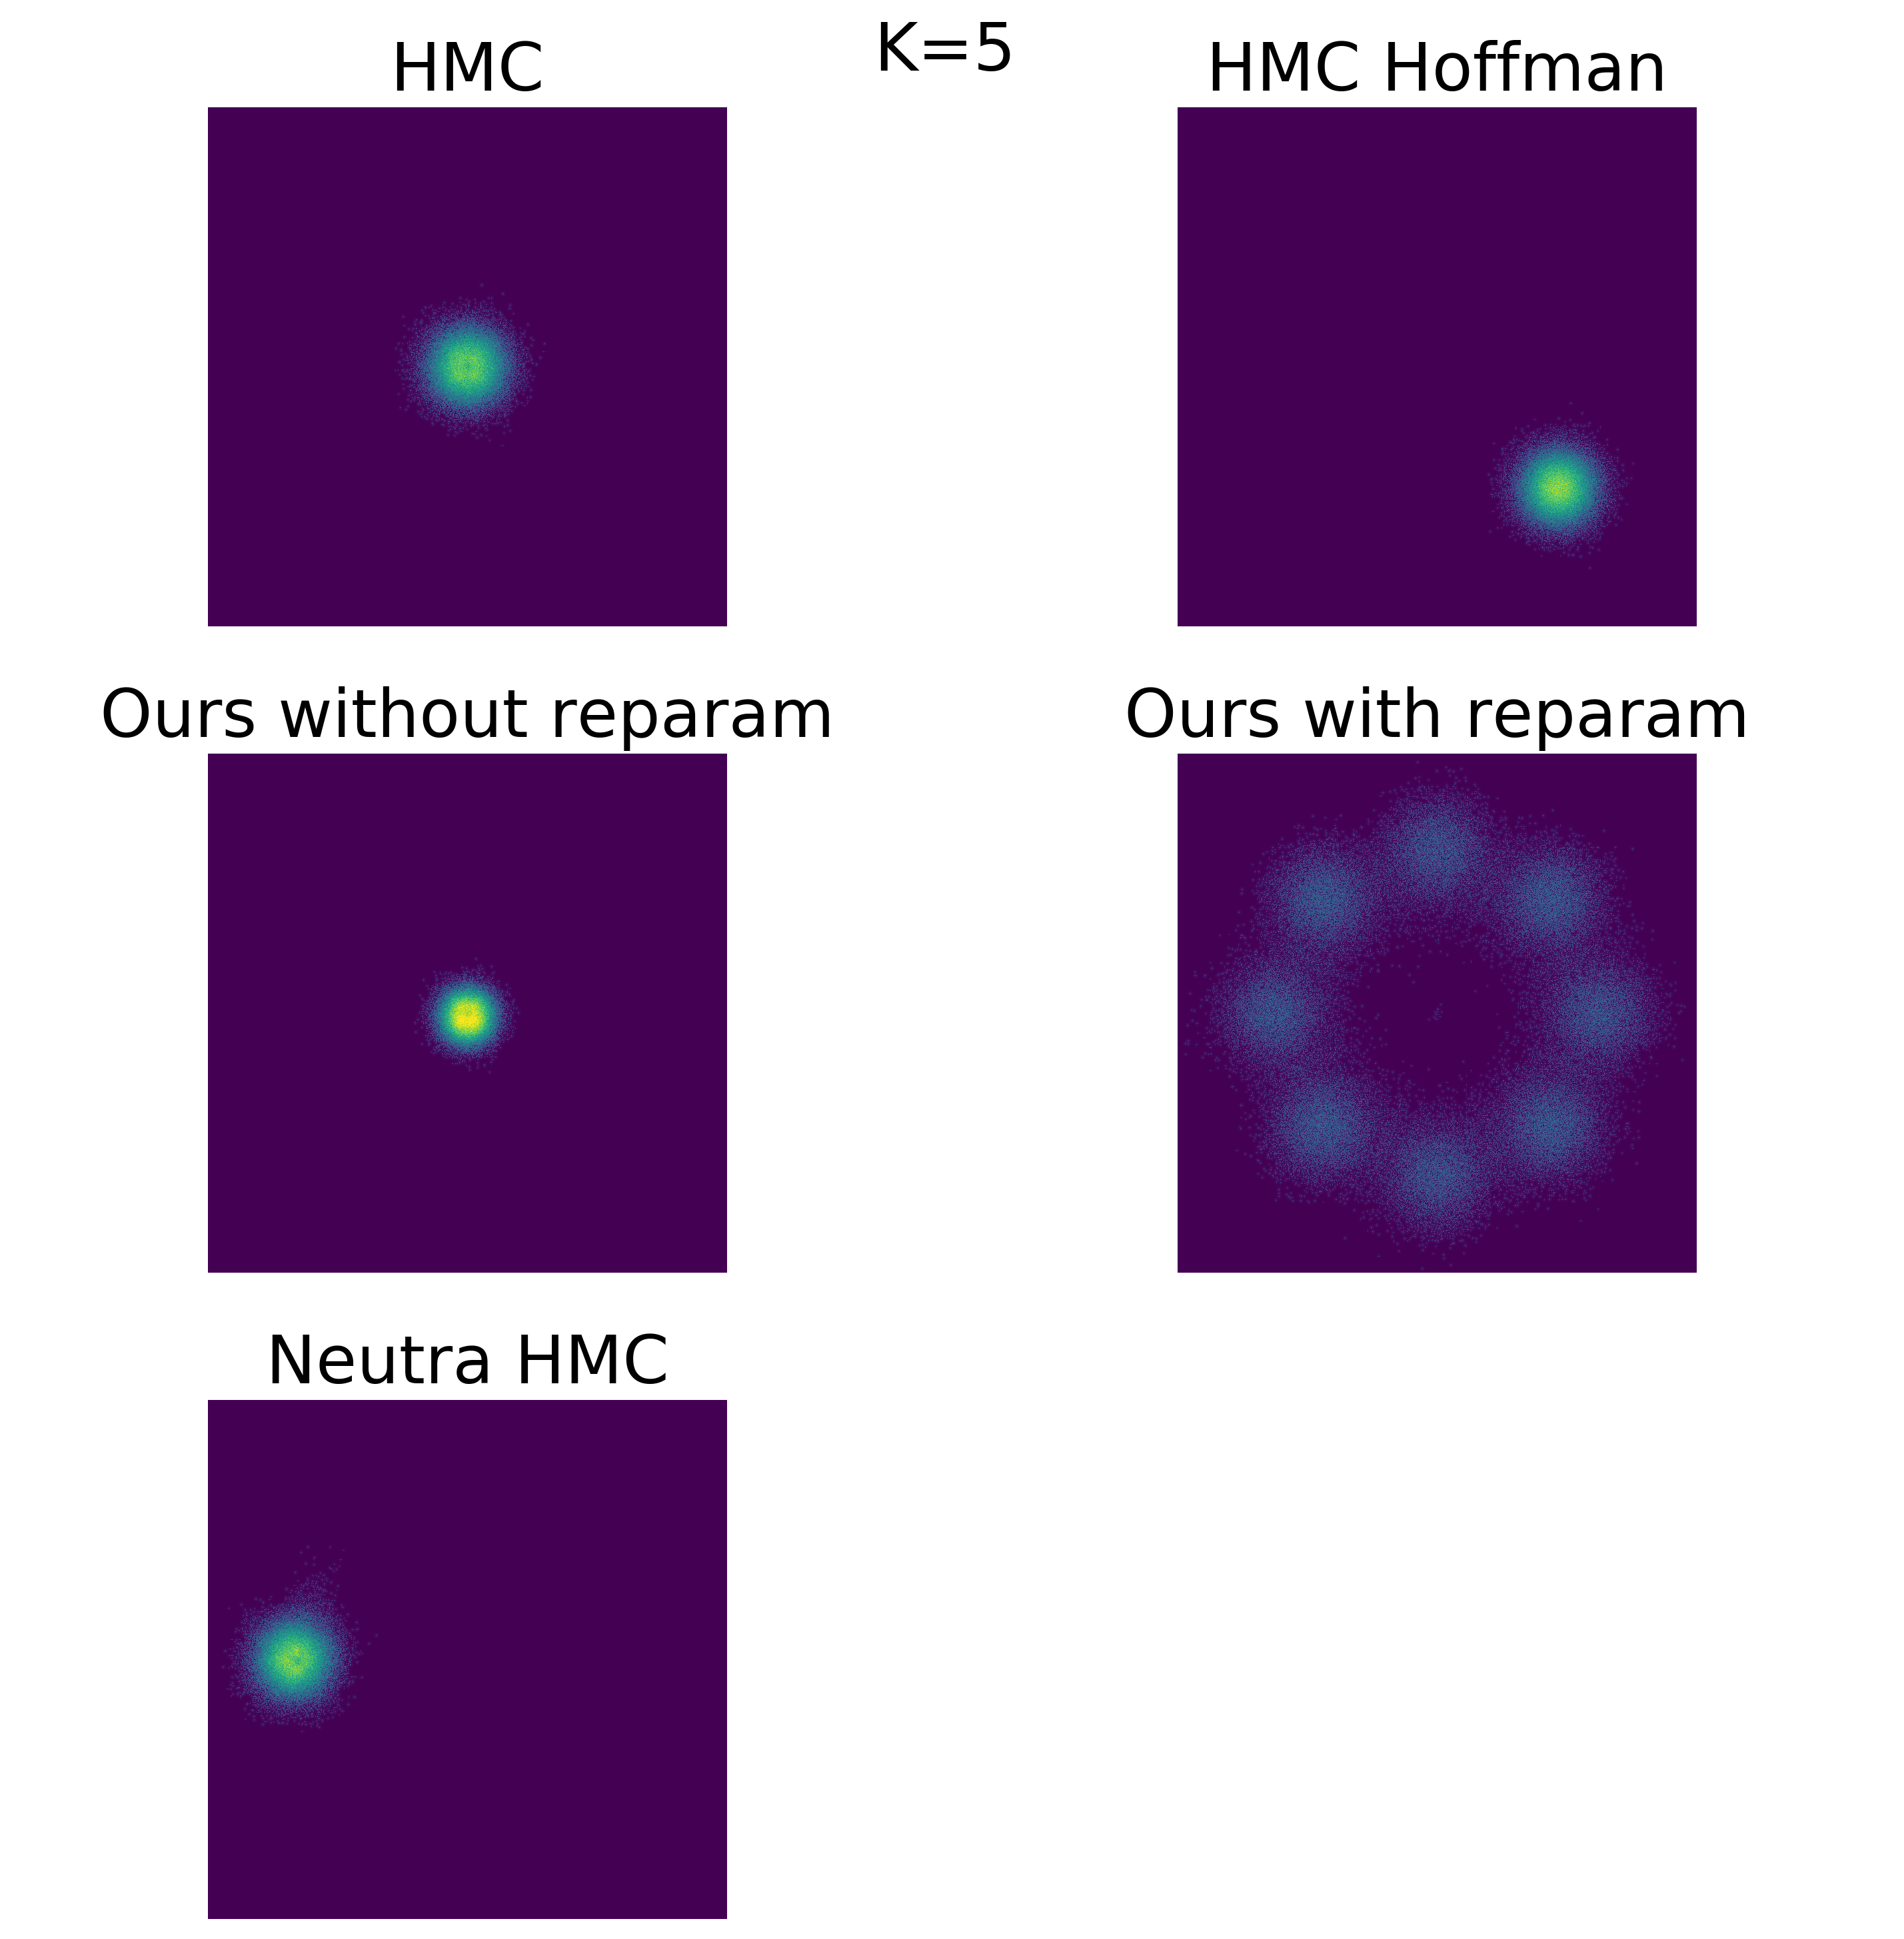

In [36]:
import matplotlib.colors as mcolors
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10, 10), dpi=300)

norm=mcolors.PowerNorm(0.4)
bins = 1000
lim_x = 15
lim_y = 15
lim_y_min = -15

##### Plotting 2d Hists
plt.suptitle('K={}'.format(args.K))

ax[0, 0].set_title('HMC')
h, _, _ = np.histogram2d(samples_hmc[:, 0], samples_hmc[:, 1],
                             bins=bins, density=True, range=[[-lim_x, lim_x], [lim_y_min, lim_y]])
ax[0, 0].axis('off')
ax[0, 0].axis('equal')
ax[0, 0].imshow(np.rot90(h), interpolation='lanczos', norm=norm)

ax[0, 1].set_title('HMC Hoffman')
h, _, _ = np.histogram2d(samples_hoff[:, 0], samples_hoff[:, 1],
                             bins=bins, density=True, range=[[-lim_x, lim_x], [lim_y_min, lim_y]])
ax[0, 1].axis('off')
ax[0, 1].axis('equal')
ax[0, 1].imshow(np.rot90(h), interpolation='lanczos', norm=norm)

ax[1, 0].set_title('Ours without reparam')
h, _, _ = np.histogram2d(samples_wo[:, 0], samples_wo[:, 1],
                             bins=bins, density=True, range=[[-lim_x, lim_x], [lim_y_min, lim_y]])
ax[1, 0].axis('off')
ax[1, 0].axis('equal')
ax[1, 0].imshow(np.rot90(h), interpolation='lanczos', norm=norm)

ax[1, 1].set_title('Ours with reparam')
h, _, _ = np.histogram2d(samples_w[:, 0], samples_w[:, 1],
                             bins=bins, density=True, range=[[-lim_x, lim_x], [lim_y_min, lim_y]])
ax[1, 1].axis('off')
ax[1, 1].axis('equal')
ax[1, 1].imshow(np.rot90(h), interpolation='lanczos', norm=norm)


ax[2, 0].set_title('Neutra HMC')
h, _, _ = np.histogram2d(samples_neutrahmc[:, 0], samples_neutrahmc[:, 1],
                             bins=bins, density=True, range=[[-lim_x, lim_x], [lim_y_min, lim_y]])
ax[2, 0].axis('off')
ax[2, 0].axis('equal')
ax[2, 0].imshow(np.rot90(h), interpolation='lanczos', norm=norm)

ax[2, 1].axis('off')
ax[2, 1].axis('equal')

# plt.subplots_adjust(left=0.25, right=1., bottom=0., top=0.85, wspace=0.1, hspace=0.15)
plt.tight_layout();
# plt.savefig('./pics_hmc/hist2d_K_{}_N_{}_gamma_{}_alpha_{}_learnreverse_{}_fixparam_{}_amortize_{}_dataname_{}.png'.format(args.K, args.N, args.gamma, args.alpha,
#                                                       args.learnable_reverse, args.fix_transition_params, args.amortize, args.data_name), format='png')

In [37]:

#     plt
#     plt.axis('off')
#     plt.axis('equal')

In [38]:
print('a')

a
